In [7]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [8]:
# -------------------------- Import Libraries --------------------------
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid
import holidays

In [6]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib
import tensorflow as tf
import pmdarima
import statsmodels
import holidays

print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("scikit-learn:", sklearn.__version__)
print("matplotlib:", matplotlib.__version__)
print("tensorflow:", tf.__version__)
print("pmdarima:", pmdarima.__version__)
print("statsmodels:", statsmodels.__version__)
print("holidays:", holidays.__version__)


pandas: 2.2.2
numpy: 1.26.4
scikit-learn: 1.2.2
matplotlib: 3.7.5
tensorflow: 2.17.1
pmdarima: 2.0.4
statsmodels: 0.14.4
holidays: 0.63


In [9]:
# Load Data
data_path = '/kaggle/input/electricity-dataset-forecasting/household_power_consumption.txt'
data = pd.read_csv(data_path, sep=';', header=0, low_memory=False)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


In [11]:
# Check data types of all columns
print("Data types of columns:")
print(data.dtypes)

# Identify non-numeric columns
non_numeric_columns = data.select_dtypes(exclude=['float64', 'int64']).columns

if len(non_numeric_columns) > 0:
    print("\nNon-numeric columns detected:")
    print(non_numeric_columns)
    
    # Check unique values in non-numeric columns (optional)
    for col in non_numeric_columns:
        print(f"\nUnique values in '{col}':")
        print(data[col].unique())
else:
    print("\nNo non-numeric columns detected. All data is numeric.")


Data types of columns:
Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

Non-numeric columns detected:
Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2'],
      dtype='object')

Unique values in 'Date':
['16/12/2006' '17/12/2006' '18/12/2006' ... '24/11/2010' '25/11/2010'
 '26/11/2010']

Unique values in 'Time':
['17:24:00' '17:25:00' '17:26:00' ... '17:21:00' '17:22:00' '17:23:00']

Unique values in 'Global_active_power':
['4.216' '5.360' '5.374' ... '9.630' '9.648' '8.600']

Unique values in 'Global_reactive_power':
['0.418' '0.436' '0.498' '0.502' '0.528' '0.522' '0.520' '0.510' '0.470'
 '0.478' '0.398' '0.422' '0.282' '0.152' '0.156

In [12]:
# Replace "?" with NaN
data.replace('?', np.nan, inplace=True)

# Handle datetime columns
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(columns=['Date', 'Time'], inplace=True)
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

In [13]:
# Convert numeric columns
numeric_cols = [
    'Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Impute missing values
data = data.interpolate(method='time').dropna()

In [14]:
# Aggregate minute-level data to daily
data_daily = data.resample('D').mean().reset_index()
data_daily.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

In [15]:
# Feature engineering
data_daily['day_of_week'] = data_daily['ds'].dt.dayofweek
data_daily['is_weekend'] = (data_daily['day_of_week'] >= 5).astype(int)
data_daily['is_holiday'] = data_daily['ds'].isin(
    pd.to_datetime(list(holidays.FR(years=data_daily['ds'].dt.year.unique())))
).astype(int)
data_daily['is_friday_and_holiday'] = ((data_daily['day_of_week'] == 4) & (data_daily['is_holiday'] == 1)).astype(int)
data_daily['is_monday_and_holiday'] = ((data_daily['day_of_week'] == 0) & (data_daily['is_holiday'] == 1)).astype(int)



# -------------------------- Train-Test Split --------------------------

In [16]:
train_size = int(len(data_daily) * 0.7)
val_size = int(len(data_daily) * 0.15)
test_size = len(data_daily) - train_size - val_size

train = data_daily.iloc[:train_size]
val = data_daily.iloc[train_size:train_size + val_size]
test = data_daily.iloc[train_size + val_size:]

print(f"Train: {len(train)} rows, Validation: {len(val)} rows, Test: {len(test)} rows")


Train: 1009 rows, Validation: 216 rows, Test: 217 rows


# ******************************************** EDA ****************************************************

<ipython-input-17-e89a18262cc7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ds'] = pd.to_datetime(train['ds'], errors='coerce')


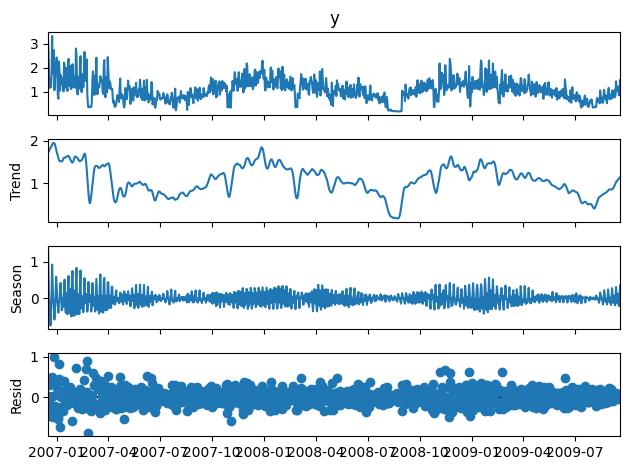

Preprocessing completed:
Missing values in data_daily: 
ds                       0
y                        0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
day_of_week              0
is_weekend               0
is_holiday               0
is_friday_and_holiday    0
is_monday_and_holiday    0
dtype: int64
Train dataset size: 1009 rows
Validation dataset size: 216 rows
Test dataset size: 217 rows


In [17]:
# -------------------------- Ensure Continuity --------------------------

# Set 'ds' as the index and ensure it's a datetime object
train['ds'] = pd.to_datetime(train['ds'], errors='coerce')
train.set_index('ds', inplace=True)

# Ensure no missing dates by reindexing
train = train.asfreq('D')  # Resample to daily frequency

# Interpolate missing values after reindexing
train['y'] = train['y'].interpolate(method='time')

# -------------------------- STL Decomposition --------------------------

# Perform STL decomposition
stl = STL(train['y'], seasonal=7)
result = stl.fit()

# Plot STL decomposition
result.plot()
plt.show()

# -------------------------- Summary --------------------------
print("Preprocessing completed:")
print(f"Missing values in data_daily: \n{data_daily.isnull().sum()}")
print(f"Train dataset size: {len(train)} rows")
print(f"Validation dataset size: {len(val)} rows")
print(f"Test dataset size: {len(test)} rows")


In [18]:
# ADF Test for stationarity
adf_test = adfuller(train['y'])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

ADF Statistic: -3.009295424101366, p-value: 0.03403539607714527


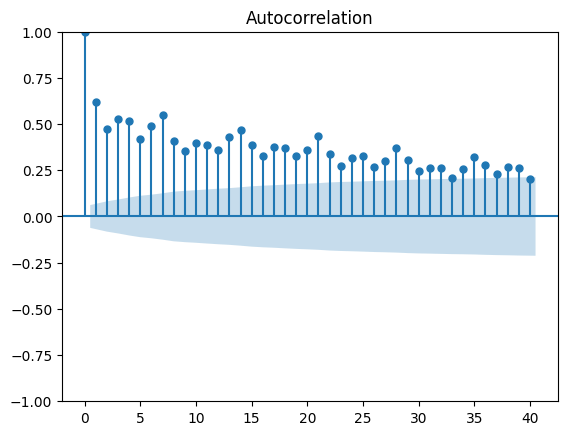

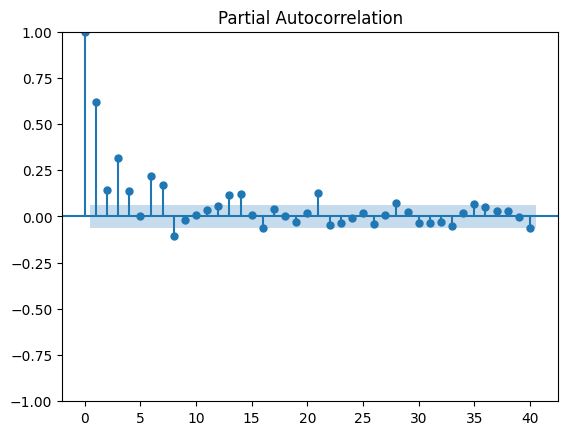

In [19]:
# Plot ACF and PACF
plot_acf(train['y'], lags=40)
plt.show()
plot_pacf(train['y'], lags=40)
plt.show()

In [20]:
# -------------------------- SARIMA Modeling --------------------------

# Function to fit SARIMA
def fit_sarima(data, order, seasonal_order, exog=None):
    model = SARIMAX(data['y'], order=order, seasonal_order=seasonal_order, exog=exog)
    results = model.fit(disp=False)
    return results

In [21]:
# --------------------- Without Covariates ---------------------
print("\nSARIMA Without Covariates:")
model_no_covariates = auto_arima(train['y'], seasonal=True, m=7, trace=True)
order_no_cov = model_no_covariates.order
seasonal_order_no_cov = model_no_covariates.seasonal_order

sarima_no_cov = fit_sarima(train, order_no_cov, seasonal_order_no_cov)

val_forecast_no_cov = sarima_no_cov.get_forecast(steps=len(val))
val_forecast_mean_no_cov = val_forecast_no_cov.predicted_mean
val_rmse_no_cov = np.sqrt(mean_squared_error(val['y'], val_forecast_mean_no_cov))
val_r2_no_cov = r2_score(val['y'], val_forecast_mean_no_cov)
print(f"Validation RMSE: {val_rmse_no_cov:.4f}, R2: {val_r2_no_cov:.4f}")


SARIMA Without Covariates:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=486.535, Time=2.37 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=964.900, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=791.355, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=632.711, Time=0.49 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=962.916, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=576.582, Time=1.75 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=568.589, Time=2.14 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=524.891, Time=3.27 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=528.770, Time=3.85 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=604.131, Time=0.88 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=570.639, Time=3.08 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=557.101, Time=2.72 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=489.113, Time=3.96 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=491.694, Time=2.03 sec
 ARIMA(2,1,1)(1,0,1

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Validation RMSE: 0.3371, R2: -0.2618


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# --------------------- With Covariates ---------------------
print("\nSARIMA With Covariates:")
covariates = ['is_weekend', 'is_holiday', 'is_friday_and_holiday', 'is_monday_and_holiday']
exog_train = train[covariates]
exog_val = val[covariates]

model_with_covariates = auto_arima(train['y'], exogenous=exog_train, seasonal=True, m=7, trace=True)
order_with_cov = model_with_covariates.order
seasonal_order_with_cov = model_with_covariates.seasonal_order

sarima_with_cov = fit_sarima(train, order_with_cov, seasonal_order_with_cov, exog=exog_train)

val_forecast_with_cov = sarima_with_cov.get_forecast(steps=len(val), exog=exog_val)
val_forecast_mean_with_cov = val_forecast_with_cov.predicted_mean
val_rmse_with_cov = np.sqrt(mean_squared_error(val['y'], val_forecast_mean_with_cov))
val_r2_with_cov = r2_score(val['y'], val_forecast_mean_with_cov)
print(f"Validation RMSE: {val_rmse_with_cov:.4f}, R2: {val_r2_with_cov:.4f}")



SARIMA With Covariates:
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=486.535, Time=2.34 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=964.900, Time=0.11 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=791.355, Time=0.36 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=632.711, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=962.916, Time=0.07 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=576.582, Time=1.80 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=568.589, Time=2.11 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=524.891, Time=3.23 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=528.770, Time=3.60 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=604.131, Time=0.86 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=570.639, Time=2.88 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=557.101, Time=2.69 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=489.113, Time=3.81 sec
 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=491.694, Time=2.04 sec
 ARIMA(2,1,1)(1,0,1)[7

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Validation RMSE: 0.3468, R2: -0.3348


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
**************** LSTM without hyper parameter *******************************

Test data has 57 days, suitable for evaluation.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.5964 - val_loss: 0.1371
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2391 - val_loss: 0.1268
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2333 - val_loss: 0.1242
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2178 - val_loss: 0.1179
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2049 - val_loss: 0.1114
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1922 - val_loss: 0.0956
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1774 - val_loss: 0.0806
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1643 - val_loss: 0.0867
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1514 - val_loss: 0.0774
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1537 - val_loss: 0.0962
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1546 - val_loss: 0.0735
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1552 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.6329 - val_loss: 0.1321
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2397 - val_loss: 0.1280
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2198 - val_loss: 0.1251
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1995 - val_loss: 0.1196
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1973 - val_loss: 0.1100
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1912 - val_loss: 0.0957
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1800 - val_loss: 0.0994
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1742 - val_loss: 0.0830
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1612 - val_loss: 0.0870
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1571 - val_loss: 0.0862
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1525 - val_loss: 0.0765
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1491 - val_loss: 0.077

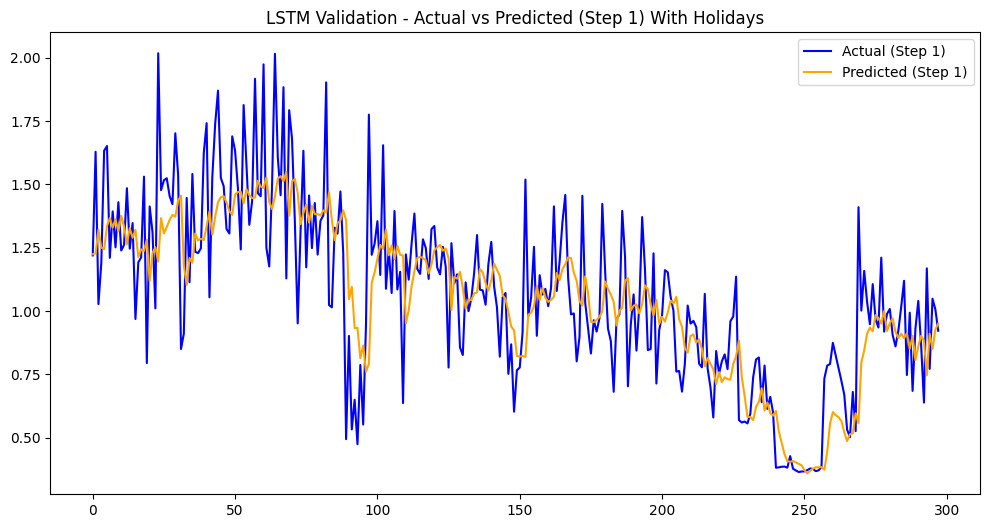

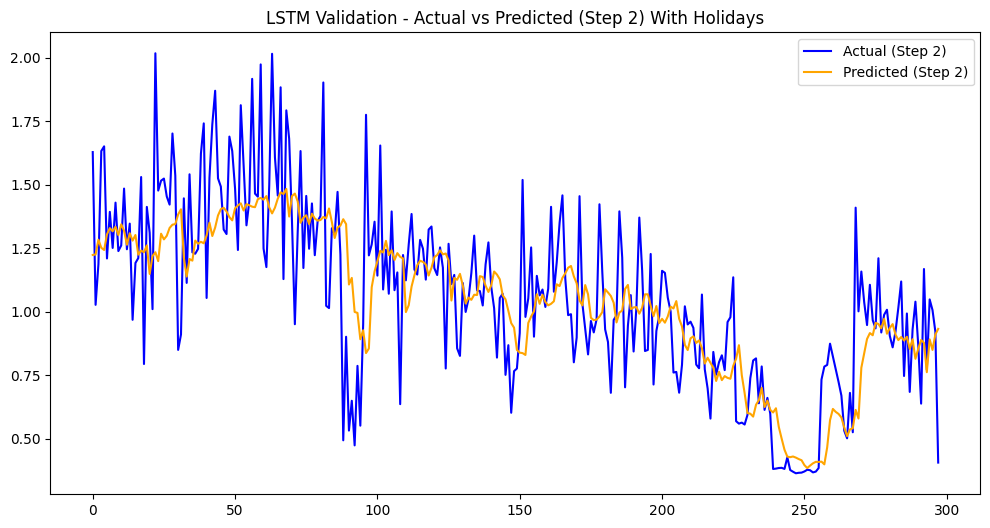

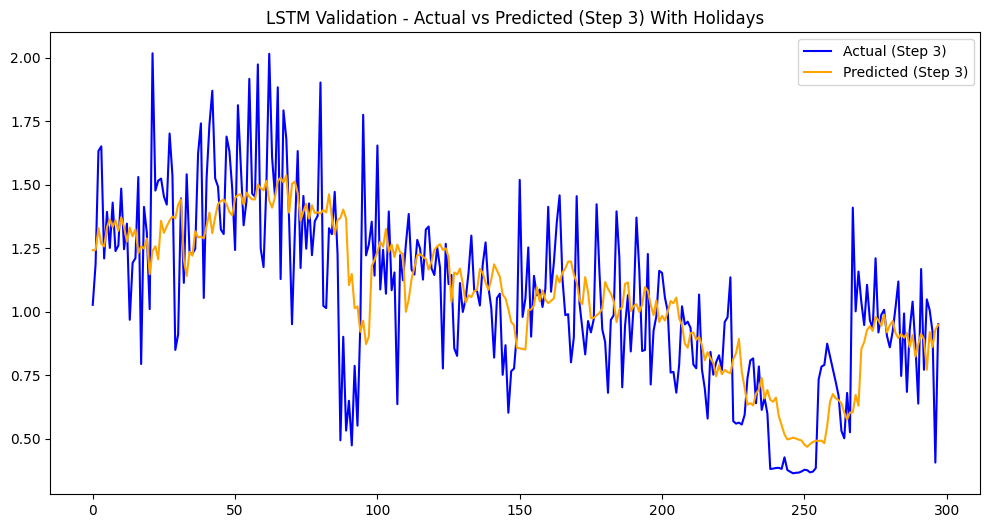

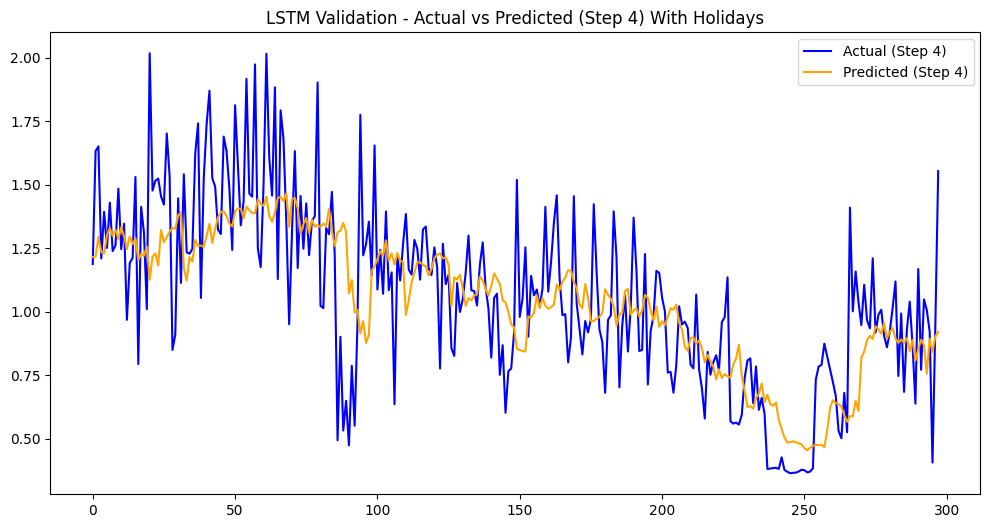

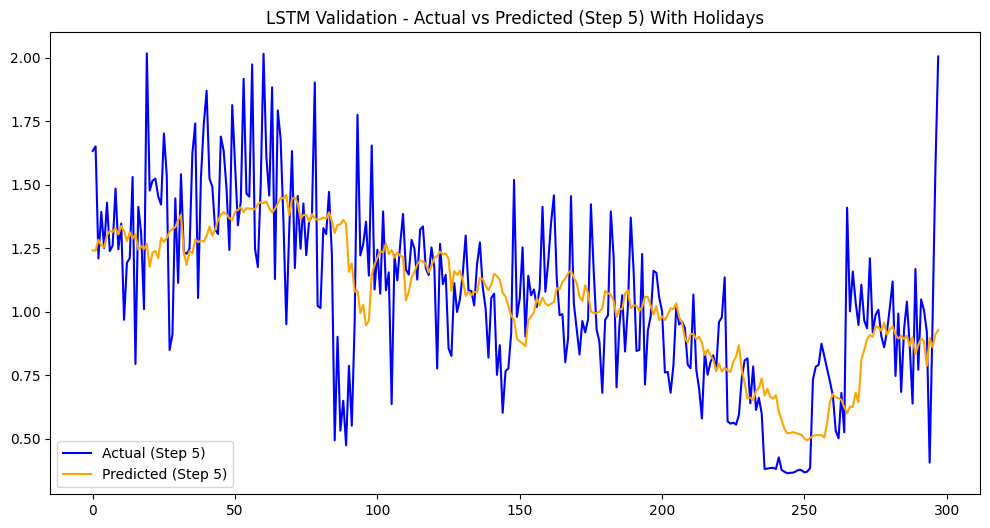

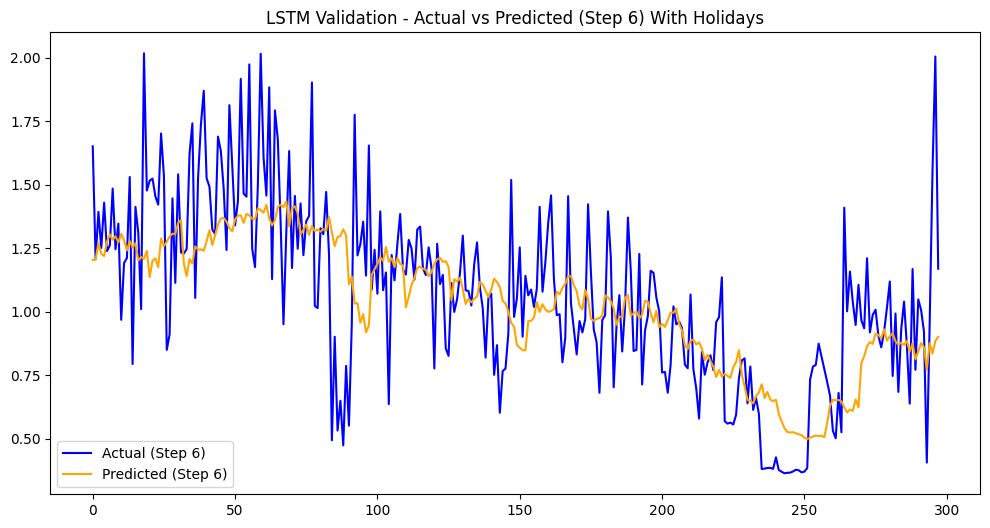

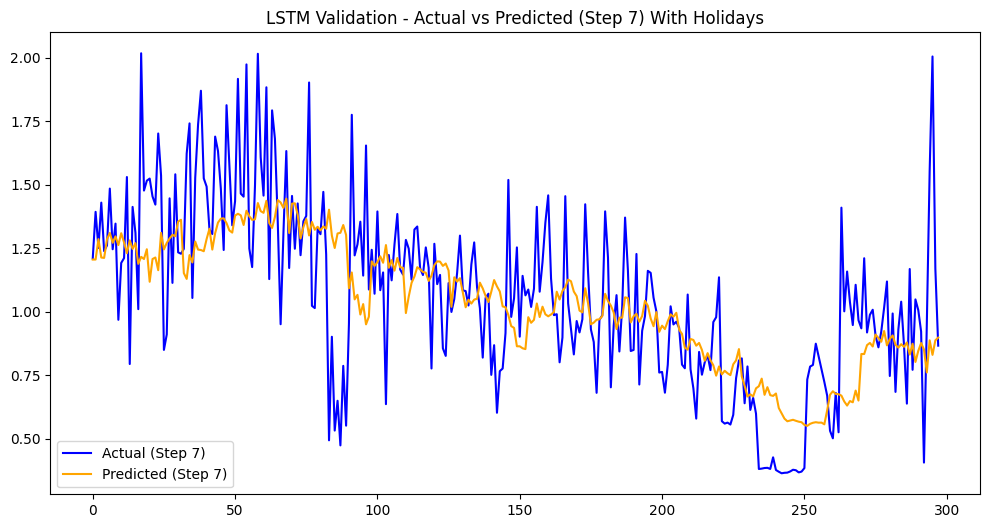

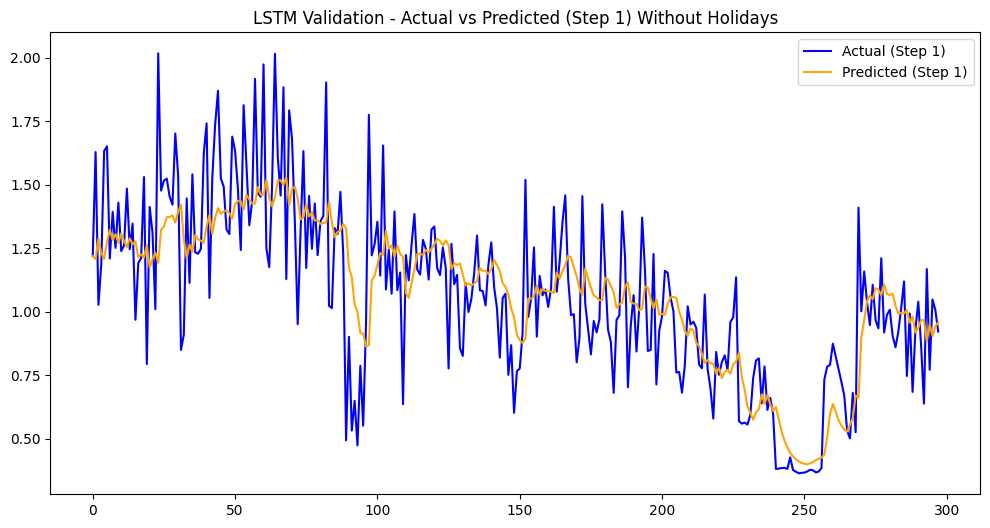

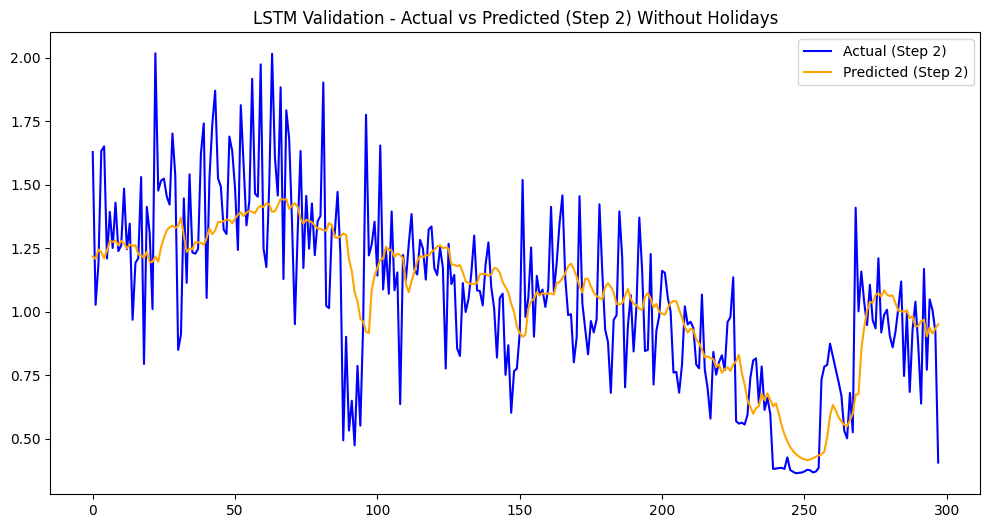

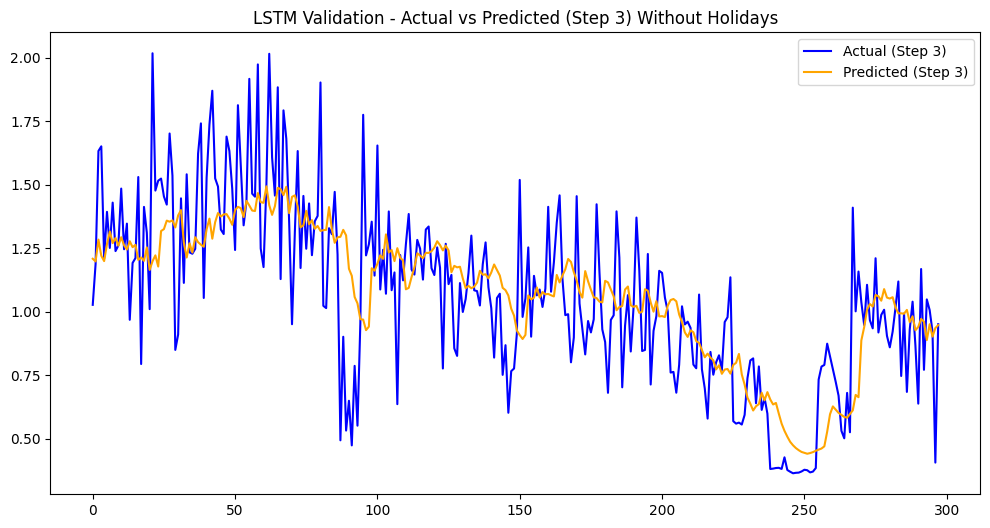

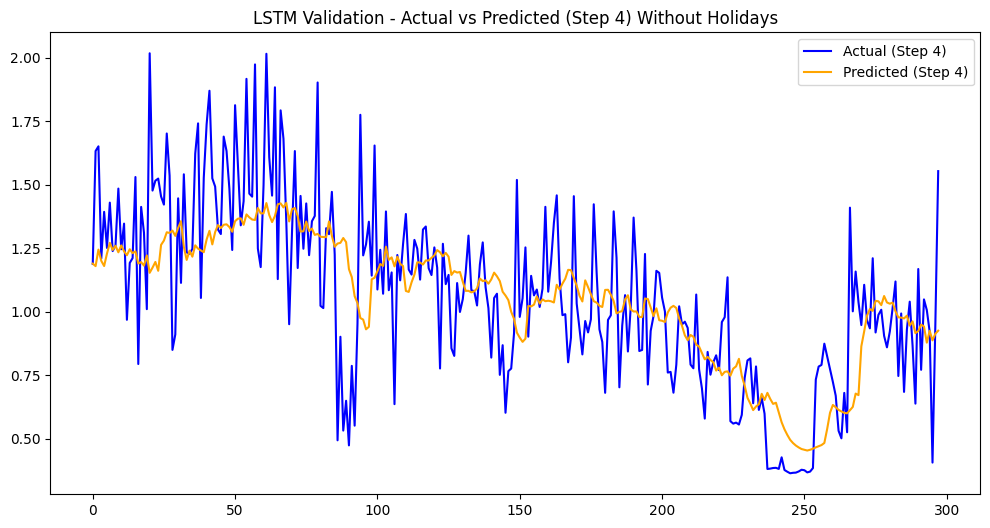

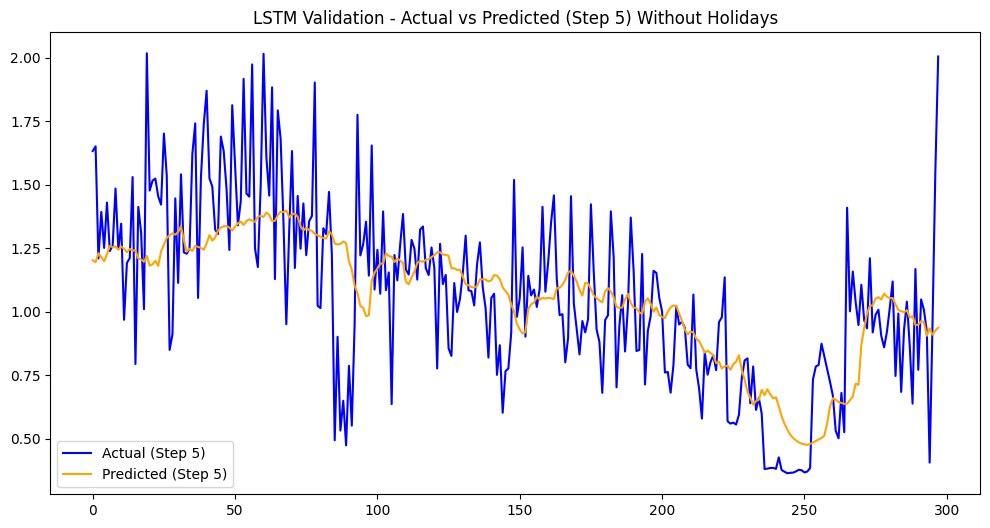

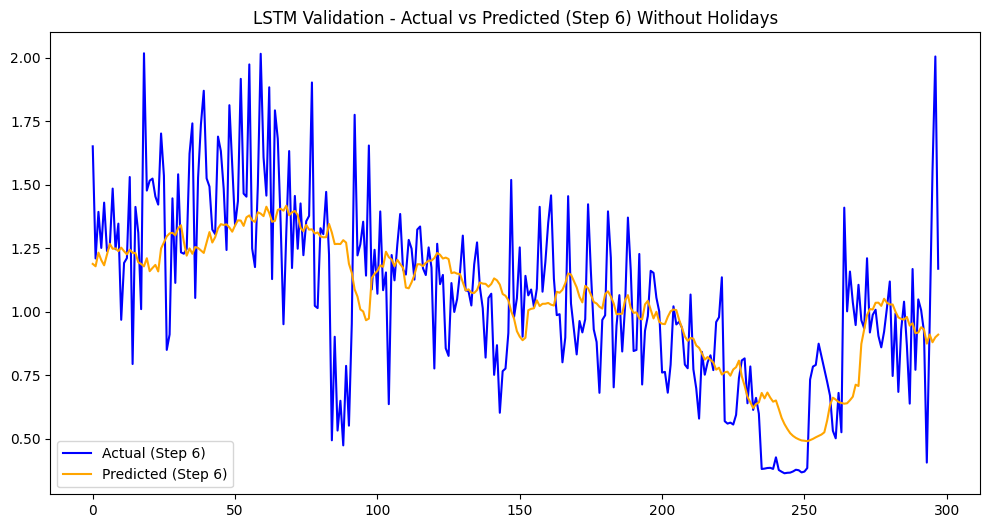

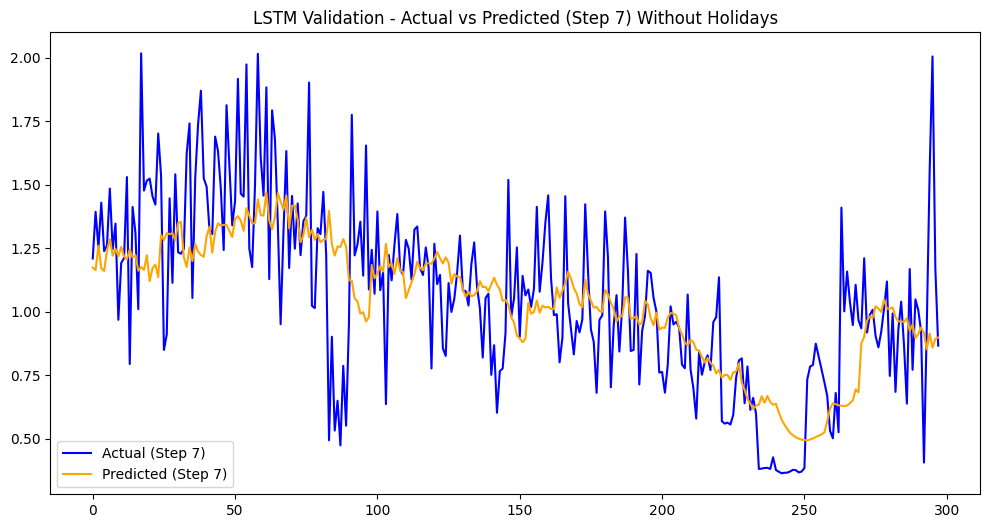

     Step  Validation RMSE (With Holidays)  Validation R2 (With Holidays)  \
0  Step 1                         0.234489                       0.564585   
1  Step 2                         0.243781                       0.534525   
2  Step 3                         0.249072                       0.510184   
3  Step 4                         0.257100                       0.481362   
4  Step 5                         0.267457                       0.451227   
5  Step 6                         0.273260                       0.422567   
6  Step 7                         0.274106                       0.414380   

   Validation RMSE (Without Holidays)  Validation R2 (Without Holidays)  
0                            0.233009                          0.570066  
1                            0.242491                          0.539437  
2                            0.246630                          0.519741  
3                            0.255209                          0.488963  
4            

In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import holidays

# Load Data
data_path = '/kaggle/input/electricity-dataset-forecasting/household_power_consumption.txt'
data = pd.read_csv(data_path, sep=';', header=0, low_memory=False)

# Handle datetime columns properly
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(columns=['Date', 'Time'], inplace=True)
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Convert numeric columns to proper data types
numeric_cols = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')
data = data.interpolate()

# Aggregate minute-level data to daily level
data_daily = data.resample('D').mean()
data_daily.reset_index(inplace=True)
data_daily.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Feature Engineering
data_daily['day_of_week'] = data_daily['ds'].dt.day_name()
data_daily['is_friday'] = (data_daily['ds'].dt.dayofweek == 4).astype(int)
data_daily['is_monday'] = (data_daily['ds'].dt.dayofweek == 0).astype(int)
data_daily['is_weekend'] = (data_daily['ds'].dt.dayofweek >= 5).astype(int)

# Add in-built holidays for France
french_holidays = pd.to_datetime(list(holidays.FR(years=data_daily['ds'].dt.year.unique())), errors='coerce')
data_daily['is_holiday'] = data_daily['ds'].isin(french_holidays).astype(int)
data_daily['is_friday_and_holiday'] = (data_daily['is_friday'] & data_daily['is_holiday']).astype(int)
data_daily['is_monday_and_holiday'] = (data_daily['is_monday'] & data_daily['is_holiday']).astype(int)

# Adjusted split ranges based on the last date in the dataset
train = data_daily[(data_daily['ds'] >= '2006-12-16') & (data_daily['ds'] < '2009-11-01')]
val = data_daily[(data_daily['ds'] >= '2009-11-01') & (data_daily['ds'] < '2010-10-01')]
test = data_daily[(data_daily['ds'] >= '2010-10-01') & (data_daily['ds'] <= '2010-11-26')]

# Validate the test split
if len(test) < 30:
    print(f"Warning: Test data has only {len(test)} days. You may need to adjust the splits.")
else:
    print(f"Test data has {len(test)} days, suitable for evaluation.")

# Reframe data for multi-step forecasting
def to_supervised(data, n_input, n_output, features):
    X, y = [], []
    data_values = data[features].values
    for i in range(len(data_values) - n_input - n_output + 1):
        X.append(data_values[i:i + n_input])
        y.append(data_values[i + n_input:i + n_input + n_output, 0])
    return np.array(X), np.array(y)

# Define input and output window sizes
n_input = 30
n_output = 7

# Features for Experiment 1 (With Holidays)
features_with_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'is_holiday',
    'is_friday_and_holiday', 'is_monday_and_holiday', 'is_weekend',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
X_train_holidays, y_train_holidays = to_supervised(train, n_input, n_output, features_with_holidays)
X_val_holidays, y_val_holidays = to_supervised(val, n_input, n_output, features_with_holidays)
X_test_holidays, y_test_holidays = to_supervised(test, n_input, n_output, features_with_holidays)

# Features for Experiment 2 (Without Holidays)
features_without_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
X_train_no_holidays, y_train_no_holidays = to_supervised(train, n_input, n_output, features_without_holidays)
X_val_no_holidays, y_val_no_holidays = to_supervised(val, n_input, n_output, features_without_holidays)
X_test_no_holidays, y_test_no_holidays = to_supervised(test, n_input, n_output, features_without_holidays)

# Build LSTM Model
def build_lstm_model(input_shape, lstm_units, dropout_rate):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_output))  # Multi-step output layer
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Train and Evaluate Model for Train/Validation
def train_and_evaluate_train_val(X_train, y_train, X_val, y_val, lstm_units=100, dropout_rate=0.3):
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), lstm_units, dropout_rate)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    y_pred_val = model.predict(X_val)

    # Calculate metrics for each step in the forecast horizon
    rmse_val = [np.sqrt(mean_squared_error(y_val[:, i], y_pred_val[:, i])) for i in range(n_output)]
    r2_val = [r2_score(y_val[:, i], y_pred_val[:, i]) for i in range(n_output)]

    return rmse_val, r2_val, model, y_pred_val

# Experiment 1: With Holidays (Train/Validation)
rmse_val_holidays, r2_val_holidays, model_holidays, y_pred_val_holidays = train_and_evaluate_train_val(
    X_train_holidays, y_train_holidays, X_val_holidays, y_val_holidays
)
print("Validation RMSE (With Holidays):", rmse_val_holidays)
print("Validation R2 (With Holidays):", r2_val_holidays)

# Experiment 2: Without Holidays (Train/Validation)
rmse_val_no_holidays, r2_val_no_holidays, model_no_holidays, y_pred_val_no_holidays = train_and_evaluate_train_val(
    X_train_no_holidays, y_train_no_holidays, X_val_no_holidays, y_val_no_holidays
)
print("Validation RMSE (Without Holidays):", rmse_val_no_holidays)
print("Validation R2 (Without Holidays):", r2_val_no_holidays)

# Visualize Results: Validation (With Holidays)
for i in range(n_output):
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_holidays[:, i], label=f'Actual (Step {i+1})', color='blue')
    plt.plot(y_pred_val_holidays[:, i], label=f'Predicted (Step {i+1})', color='orange')
    plt.title(f'LSTM Validation - Actual vs Predicted (Step {i+1}) With Holidays')
    plt.legend()
    plt.show()

# Visualize Results: Validation (Without Holidays)
for i in range(n_output):
    plt.figure(figsize=(12, 6))
    plt.plot(y_val_no_holidays[:, i], label=f'Actual (Step {i+1})', color='blue')
    plt.plot(y_pred_val_no_holidays[:, i], label=f'Predicted (Step {i+1})', color='orange')
    plt.title(f'LSTM Validation - Actual vs Predicted (Step {i+1}) Without Holidays')
    plt.legend()
    plt.show()

# Summarize Validation Results
validation_results = pd.DataFrame({
    'Step': [f'Step {i+1}' for i in range(n_output)],
    'Validation RMSE (With Holidays)': rmse_val_holidays,
    'Validation R2 (With Holidays)': r2_val_holidays,
    'Validation RMSE (Without Holidays)': rmse_val_no_holidays,
    'Validation R2 (Without Holidays)': r2_val_no_holidays
})
print(validation_results)



In [ ]:
#**************************************************LSTM Model with hyperparameter *******************************************

Test data has 57 days, suitable for evaluation.
Training with params: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'lstm_units': 128}
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5109 - val_loss: 0.1270
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2166 - val_loss: 0.0977
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1733 - val_loss: 0.1094
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1584 - val_loss: 0.1114
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1544 - val_loss: 0.0775
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1442 - val_loss: 0.0772
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1356 - val_loss: 0.0760
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1401 - val_loss: 0.0720
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1324 - val_loss: 0.0993
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1395 - val_loss: 0.0715
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1318 - val_loss: 0.0756
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1253 - val_loss: 0.0761

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3696 - val_loss: 0.1260
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1867 - val_loss: 0.1155
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1708 - val_loss: 0.0831
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1445 - val_loss: 0.0780
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1581 - val_loss: 0.0980
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1469 - val_loss: 0.0868
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1266 - val_loss: 0.0985
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1434 - val_loss: 0.0849
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1369 - val_loss: 0.1004
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1321 - val_loss: 0.0718
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1250 - val_loss: 0.0913
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1319 - val_loss: 0.1058

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6488 - val_loss: 0.1371
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2348 - val_loss: 0.1274
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2054 - val_loss: 0.1121
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1721 - val_loss: 0.0807
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1668 - val_loss: 0.0729
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1403 - val_loss: 0.0785
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1495 - val_loss: 0.0804
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1371 - val_loss: 0.0741
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1337 - val_loss: 0.0762
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1367 - val_loss: 0.0786
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1330 - val_loss: 0.0775
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1341 - val_loss: 0.0830

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3933 - val_loss: 0.1285
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2054 - val_loss: 0.1155
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1689 - val_loss: 0.0866
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1565 - val_loss: 0.0805
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1515 - val_loss: 0.1292
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1509 - val_loss: 0.0999
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1467 - val_loss: 0.0999
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1446 - val_loss: 0.1037
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1402 - val_loss: 0.0819
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1288 - val_loss: 0.0856
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1292 - val_loss: 0.0769
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1345 - val_loss: 0.0746

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5034 - val_loss: 0.1276
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2148 - val_loss: 0.1192
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2017 - val_loss: 0.1057
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1741 - val_loss: 0.0995
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1664 - val_loss: 0.0775
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1530 - val_loss: 0.0749
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1429 - val_loss: 0.0832
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1430 - val_loss: 0.0808
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1335 - val_loss: 0.0900
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1405 - val_loss: 0.0863
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1340 - val_loss: 0.0770
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1457 - val_loss: 0.0714

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4902 - val_loss: 0.1297
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2011 - val_loss: 0.1073
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1770 - val_loss: 0.0861
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1625 - val_loss: 0.0882
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1553 - val_loss: 0.0760
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1454 - val_loss: 0.0731
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1354 - val_loss: 0.0732
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1358 - val_loss: 0.0709
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1377 - val_loss: 0.0792
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1320 - val_loss: 0.0766
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1328 - val_loss: 0.0701
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1276 - val_loss: 0.0727

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6934 - val_loss: 0.1361
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2439 - val_loss: 0.1282
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2310 - val_loss: 0.1277
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2108 - val_loss: 0.1184
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2107 - val_loss: 0.1001
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1708 - val_loss: 0.0776
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1636 - val_loss: 0.0740
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1515 - val_loss: 0.0786
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1535 - val_loss: 0.0768
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1489 - val_loss: 0.0745
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1383 - val_loss: 0.0802
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1428 - val_loss: 0.0766

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.5340 - val_loss: 0.1226
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2057 - val_loss: 0.0996
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1827 - val_loss: 0.0802
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1542 - val_loss: 0.0749
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1383 - val_loss: 0.0863
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1438 - val_loss: 0.0745
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1366 - val_loss: 0.0724
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1415 - val_loss: 0.1267
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1397 - val_loss: 0.0697
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1418 - val_loss: 0.0868
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1320 - val_loss: 0.0737
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1375 - val_loss: 0.0683

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5356 - val_loss: 0.1302
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2387 - val_loss: 0.1197
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2104 - val_loss: 0.0949
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1782 - val_loss: 0.0786
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1602 - val_loss: 0.1003
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1578 - val_loss: 0.0840
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1490 - val_loss: 0.0816
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1430 - val_loss: 0.0777
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1437 - val_loss: 0.0735
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1466 - val_loss: 0.0724
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1522 - val_loss: 0.0736
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1471 - val_loss: 0.0786

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.4720 - val_loss: 0.1378
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2344 - val_loss: 0.1240
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2106 - val_loss: 0.1154
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1803 - val_loss: 0.0986
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1720 - val_loss: 0.0838
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1552 - val_loss: 0.0770
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1522 - val_loss: 0.0792
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1409 - val_loss: 0.0851
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1446 - val_loss: 0.0772
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1335 - val_loss: 0.0907
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1320 - val_loss: 0.0742
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1410 - val_loss: 0.0748

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5726 - val_loss: 0.1303
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2440 - val_loss: 0.1257
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2268 - val_loss: 0.1173
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2174 - val_loss: 0.1040
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1893 - val_loss: 0.0772
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1729 - val_loss: 0.0754
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1630 - val_loss: 0.0749
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1664 - val_loss: 0.0771
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1485 - val_loss: 0.0723
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1530 - val_loss: 0.0778
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1582 - val_loss: 0.0822
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1558 - val_loss: 0.0726

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5156 - val_loss: 0.1333
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2313 - val_loss: 0.1292
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2158 - val_loss: 0.1076
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1966 - val_loss: 0.0755
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1770 - val_loss: 0.0801
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1590 - val_loss: 0.0714
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1501 - val_loss: 0.0721
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1516 - val_loss: 0.0718
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1413 - val_loss: 0.0753
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1565 - val_loss: 0.0723
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1449 - val_loss: 0.0805
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1450 - val_loss: 0.0709

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8875 - val_loss: 0.1417
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2256 - val_loss: 0.1280
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2220 - val_loss: 0.1258
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2080 - val_loss: 0.1170
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1878 - val_loss: 0.0915
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1658 - val_loss: 0.0802
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1559 - val_loss: 0.0730
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1394 - val_loss: 0.0756
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1420 - val_loss: 0.0713
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1358 - val_loss: 0.0718
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1382 - val_loss: 0.0750
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1378 - val_loss: 0.070

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4720 - val_loss: 0.1321
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2108 - val_loss: 0.1286
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1889 - val_loss: 0.1180
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1949 - val_loss: 0.0963
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1655 - val_loss: 0.0819
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1499 - val_loss: 0.0802
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1326 - val_loss: 0.0896
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1399 - val_loss: 0.0738
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1321 - val_loss: 0.0887
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1393 - val_loss: 0.0838
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1357 - val_loss: 0.0735
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1277 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5972 - val_loss: 0.1498
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2314 - val_loss: 0.1330
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2064 - val_loss: 0.1242
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2114 - val_loss: 0.1094
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1913 - val_loss: 0.0961
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1734 - val_loss: 0.0975
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1690 - val_loss: 0.0972
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1568 - val_loss: 0.0766
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1514 - val_loss: 0.0755
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1443 - val_loss: 0.0881
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1382 - val_loss: 0.0762
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1379 - val_loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4547 - val_loss: 0.1391
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2113 - val_loss: 0.1284
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2026 - val_loss: 0.1201
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1986 - val_loss: 0.1187
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1891 - val_loss: 0.0981
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1624 - val_loss: 0.0886
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1521 - val_loss: 0.0817
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1542 - val_loss: 0.0756
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1451 - val_loss: 0.0793
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1395 - val_loss: 0.0788
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1362 - val_loss: 0.1025
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1393 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.5871 - val_loss: 0.1366
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2663 - val_loss: 0.1289
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2304 - val_loss: 0.1273
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2109 - val_loss: 0.1264
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2223 - val_loss: 0.1200
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1975 - val_loss: 0.1095
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2035 - val_loss: 0.0925
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1707 - val_loss: 0.0771
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1604 - val_loss: 0.0813
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1596 - val_loss: 0.1004
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1717 - val_loss: 0.0744
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1444 - val_loss: 0.078

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.4342 - val_loss: 0.1313
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2176 - val_loss: 0.1315
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2052 - val_loss: 0.1056
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1749 - val_loss: 0.0972
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1576 - val_loss: 0.0967
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1692 - val_loss: 0.0927
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1548 - val_loss: 0.0773
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1530 - val_loss: 0.0901
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1445 - val_loss: 0.0886
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1483 - val_loss: 0.0795
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1544 - val_loss: 0.0820
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1371 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7904 - val_loss: 0.1701
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2763 - val_loss: 0.1345
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2473 - val_loss: 0.1272
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2291 - val_loss: 0.1242
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2115 - val_loss: 0.1192
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2027 - val_loss: 0.1073
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1903 - val_loss: 0.0983
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1834 - val_loss: 0.0848
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1729 - val_loss: 0.0808
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1641 - val_loss: 0.0778
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1644 - val_loss: 0.0774
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1493 - val_loss: 0.08

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4724 - val_loss: 0.1595
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2384 - val_loss: 0.1250
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2026 - val_loss: 0.1153
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1914 - val_loss: 0.1048
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1877 - val_loss: 0.0987
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1658 - val_loss: 0.0969
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1556 - val_loss: 0.1055
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1542 - val_loss: 0.0783
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1544 - val_loss: 0.0948
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1466 - val_loss: 0.0891
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1354 - val_loss: 0.0874
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1420 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.9607 - val_loss: 0.1366
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2708 - val_loss: 0.1314
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2492 - val_loss: 0.1279
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2410 - val_loss: 0.1222
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2270 - val_loss: 0.1127
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1912 - val_loss: 0.1195
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1956 - val_loss: 0.0889
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1718 - val_loss: 0.0922
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1689 - val_loss: 0.0757
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1671 - val_loss: 0.0815
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1555 - val_loss: 0.0746
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1658 - val_loss: 0.073

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5053 - val_loss: 0.1405
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2307 - val_loss: 0.1251
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2128 - val_loss: 0.1165
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1900 - val_loss: 0.0947
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1723 - val_loss: 0.1262
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1546 - val_loss: 0.0866
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1566 - val_loss: 0.0727
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1475 - val_loss: 0.0719
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1471 - val_loss: 0.0748
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1487 - val_loss: 0.0723
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1433 - val_loss: 0.0805
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1366 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7838 - val_loss: 0.1704
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3118 - val_loss: 0.1364
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2635 - val_loss: 0.1304
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2416 - val_loss: 0.1256
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2353 - val_loss: 0.1173
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2066 - val_loss: 0.0953
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1925 - val_loss: 0.1117
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1849 - val_loss: 0.0796
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1991 - val_loss: 0.0916
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1722 - val_loss: 0.0811
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1723 - val_loss: 0.0969
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1768 - val_loss: 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5601 - val_loss: 0.1610
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2572 - val_loss: 0.1345
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2245 - val_loss: 0.1267
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2167 - val_loss: 0.1223
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2182 - val_loss: 0.1154
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2030 - val_loss: 0.1050
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1810 - val_loss: 0.0868
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1668 - val_loss: 0.0829
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1604 - val_loss: 0.0751
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1603 - val_loss: 0.1049
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1552 - val_loss: 0.0912
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1499 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.5105 - val_loss: 0.1305
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2080 - val_loss: 0.1223
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1890 - val_loss: 0.0944
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1654 - val_loss: 0.0849
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1387 - val_loss: 0.0741
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1360 - val_loss: 0.0739
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1425 - val_loss: 0.0751
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1319 - val_loss: 0.0897
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1373 - val_loss: 0.0761
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1339 - val_loss: 0.0745
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1338 - val_loss: 0.0861
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1366 - val_loss: 0.0722

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3477 - val_loss: 0.1318
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1991 - val_loss: 0.1166
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1818 - val_loss: 0.0961
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1608 - val_loss: 0.1008
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1613 - val_loss: 0.1162
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1517 - val_loss: 0.0932
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1299 - val_loss: 0.0779
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1326 - val_loss: 0.0783
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1320 - val_loss: 0.0851
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1329 - val_loss: 0.0832
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1287 - val_loss: 0.0732
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1236 - val_loss: 0.0804

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5937 - val_loss: 0.1341
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2277 - val_loss: 0.1301
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2193 - val_loss: 0.1213
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1934 - val_loss: 0.1055
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1803 - val_loss: 0.0866
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1565 - val_loss: 0.0827
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1476 - val_loss: 0.0751
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1422 - val_loss: 0.0798
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1495 - val_loss: 0.0758
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1412 - val_loss: 0.0757
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1481 - val_loss: 0.0745
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1431 - val_loss: 0.0786

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.4448 - val_loss: 0.1318
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2071 - val_loss: 0.1228
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1846 - val_loss: 0.1067
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1538 - val_loss: 0.0775
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1449 - val_loss: 0.0792
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1304 - val_loss: 0.0777
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1400 - val_loss: 0.0729
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1326 - val_loss: 0.0782
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1294 - val_loss: 0.0718
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1303 - val_loss: 0.0860
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1341 - val_loss: 0.0793
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1296 - val_loss: 0.0694

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5187 - val_loss: 0.1288
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2300 - val_loss: 0.1188
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1960 - val_loss: 0.0986
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1731 - val_loss: 0.0914
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1583 - val_loss: 0.0769
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1518 - val_loss: 0.0731
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1514 - val_loss: 0.0771
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1483 - val_loss: 0.0747
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1403 - val_loss: 0.0744
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1499 - val_loss: 0.1139
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1474 - val_loss: 0.0763
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1484 - val_loss: 0.0718

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4902 - val_loss: 0.1397
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2144 - val_loss: 0.1268
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1882 - val_loss: 0.1065
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1723 - val_loss: 0.0753
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1535 - val_loss: 0.1224
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1535 - val_loss: 0.0761
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1341 - val_loss: 0.0826
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1333 - val_loss: 0.0923
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1389 - val_loss: 0.0841
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1310 - val_loss: 0.0731
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1402 - val_loss: 0.0719
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1300 - val_loss: 0.0746

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6476 - val_loss: 0.1363
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2365 - val_loss: 0.1272
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2223 - val_loss: 0.1170
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1951 - val_loss: 0.1056
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1790 - val_loss: 0.0772
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1617 - val_loss: 0.0875
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1586 - val_loss: 0.0742
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1446 - val_loss: 0.0913
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1640 - val_loss: 0.0809
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1392 - val_loss: 0.0758
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1440 - val_loss: 0.0725
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1397 - val_loss: 0.0735

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3821 - val_loss: 0.1316
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2028 - val_loss: 0.1294
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2047 - val_loss: 0.1044
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1706 - val_loss: 0.0917
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1418 - val_loss: 0.0758
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1570 - val_loss: 0.0762
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1403 - val_loss: 0.0721
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1395 - val_loss: 0.0923
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1426 - val_loss: 0.0812
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1372 - val_loss: 0.0719
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1308 - val_loss: 0.0720
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1339 - val_loss: 0.0752

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5663 - val_loss: 0.1311
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2349 - val_loss: 0.1219
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1997 - val_loss: 0.1101
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2022 - val_loss: 0.0906
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1748 - val_loss: 0.0862
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1625 - val_loss: 0.0750
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1533 - val_loss: 0.0796
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1738 - val_loss: 0.0765
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1482 - val_loss: 0.0738
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1510 - val_loss: 0.0775
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1443 - val_loss: 0.0797
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1475 - val_loss: 0.0729

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.4870 - val_loss: 0.1404
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2248 - val_loss: 0.1265
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1961 - val_loss: 0.1022
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1742 - val_loss: 0.1096
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1669 - val_loss: 0.0772
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1552 - val_loss: 0.0803
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1464 - val_loss: 0.0872
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1491 - val_loss: 0.0741
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1421 - val_loss: 0.0856
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1329 - val_loss: 0.0741
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1404 - val_loss: 0.0777
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1370 - val_loss: 0.0995

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6596 - val_loss: 0.1368
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2580 - val_loss: 0.1277
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2216 - val_loss: 0.1114
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1996 - val_loss: 0.1077
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1882 - val_loss: 0.0755
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1736 - val_loss: 0.0746
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1692 - val_loss: 0.0808
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1605 - val_loss: 0.0740
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1634 - val_loss: 0.0885
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1521 - val_loss: 0.0731
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1527 - val_loss: 0.0764
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1516 - val_loss: 0.0751

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.6649 - val_loss: 0.1307
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2287 - val_loss: 0.1261
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2184 - val_loss: 0.1206
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2035 - val_loss: 0.1034
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1977 - val_loss: 0.0860
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1669 - val_loss: 0.0800
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1548 - val_loss: 0.0774
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1447 - val_loss: 0.0747
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1451 - val_loss: 0.0763
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1422 - val_loss: 0.0820
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1428 - val_loss: 0.0733
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1394 - val_loss: 0.0739

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5788 - val_loss: 0.1349
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2282 - val_loss: 0.1286
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2186 - val_loss: 0.1284
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2034 - val_loss: 0.1183
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1908 - val_loss: 0.1023
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1718 - val_loss: 0.0860
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1618 - val_loss: 0.0780
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1473 - val_loss: 0.0832
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1532 - val_loss: 0.0764
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1443 - val_loss: 0.0751
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1458 - val_loss: 0.0962
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1399 - val_loss: 0.08

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5547 - val_loss: 0.1332
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2048 - val_loss: 0.1322
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1985 - val_loss: 0.1264
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1903 - val_loss: 0.1223
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1846 - val_loss: 0.1114
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1710 - val_loss: 0.1017
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1627 - val_loss: 0.0829
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1421 - val_loss: 0.0751
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1354 - val_loss: 0.0782
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1434 - val_loss: 0.0814
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1254 - val_loss: 0.0795
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1301 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.6291 - val_loss: 0.1548
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2381 - val_loss: 0.1304
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2097 - val_loss: 0.1183
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2009 - val_loss: 0.1131
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1924 - val_loss: 0.0994
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1815 - val_loss: 0.0907
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1665 - val_loss: 0.0866
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1556 - val_loss: 0.0775
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1476 - val_loss: 0.0733
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1498 - val_loss: 0.0880
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1529 - val_loss: 0.0750
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1484 - val_loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5935 - val_loss: 0.1452
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2143 - val_loss: 0.1277
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1999 - val_loss: 0.1254
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1873 - val_loss: 0.0924
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1625 - val_loss: 0.0786
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1619 - val_loss: 0.0796
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1551 - val_loss: 0.0764
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1440 - val_loss: 0.0831
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1368 - val_loss: 0.0842
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1353 - val_loss: 0.0953
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1316 - val_loss: 0.0748
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1418 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.6161 - val_loss: 0.1151
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2275 - val_loss: 0.1147
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1971 - val_loss: 0.0891
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1732 - val_loss: 0.1204
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1721 - val_loss: 0.0787
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1631 - val_loss: 0.0805
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1593 - val_loss: 0.0756
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1593 - val_loss: 0.0841
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1503 - val_loss: 0.0829
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1504 - val_loss: 0.1028
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1517 - val_loss: 0.0853
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1399 - val_loss: 0.07

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5910 - val_loss: 0.1299
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2342 - val_loss: 0.1349
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2097 - val_loss: 0.1283
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2101 - val_loss: 0.1228
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2027 - val_loss: 0.1112
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1752 - val_loss: 0.0859
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1550 - val_loss: 0.1118
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1568 - val_loss: 0.0764
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1413 - val_loss: 0.0799
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1363 - val_loss: 0.0846
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1434 - val_loss: 0.0914
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1337 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.7508 - val_loss: 0.1659
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2746 - val_loss: 0.1353
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2336 - val_loss: 0.1285
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2282 - val_loss: 0.1193
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2163 - val_loss: 0.1101
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1898 - val_loss: 0.1013
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1909 - val_loss: 0.0832
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1672 - val_loss: 0.0883
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1680 - val_loss: 0.0810
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1691 - val_loss: 0.0775
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1525 - val_loss: 0.0833
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1481 - val_loss: 0.1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.7267 - val_loss: 0.1519
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2562 - val_loss: 0.1326
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2243 - val_loss: 0.1281
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2038 - val_loss: 0.1289
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2160 - val_loss: 0.1141
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1903 - val_loss: 0.1007
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1755 - val_loss: 0.1018
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1605 - val_loss: 0.0835
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1488 - val_loss: 0.0798
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1458 - val_loss: 0.0758
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1484 - val_loss: 0.0735
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1398 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.5379 - val_loss: 0.1480
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2581 - val_loss: 0.1307
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2292 - val_loss: 0.1285
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2263 - val_loss: 0.1244
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2225 - val_loss: 0.1189
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2036 - val_loss: 0.0955
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1851 - val_loss: 0.0875
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1745 - val_loss: 0.0828
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1596 - val_loss: 0.1137
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1542 - val_loss: 0.0850
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1527 - val_loss: 0.0921
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1451 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5555 - val_loss: 0.1337
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2270 - val_loss: 0.1277
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2028 - val_loss: 0.1229
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1938 - val_loss: 0.1049
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1693 - val_loss: 0.1146
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1619 - val_loss: 0.0805
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1495 - val_loss: 0.0750
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1434 - val_loss: 0.0942
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1453 - val_loss: 0.0800
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1468 - val_loss: 0.0750
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1375 - val_loss: 0.0786
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1360 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.0220 - val_loss: 0.1572
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3227 - val_loss: 0.1314
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2654 - val_loss: 0.1203
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2349 - val_loss: 0.1104
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2209 - val_loss: 0.0959
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2072 - val_loss: 0.0861
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1913 - val_loss: 0.0876
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1811 - val_loss: 0.0904
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1782 - val_loss: 0.0783
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1755 - val_loss: 0.0835
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1668 - val_loss: 0.0795
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1721 - val_loss: 0.08

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.6785 - val_loss: 0.1574
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2616 - val_loss: 0.1285
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2283 - val_loss: 0.1171
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2056 - val_loss: 0.0982
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1877 - val_loss: 0.1146
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1681 - val_loss: 0.0953
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1566 - val_loss: 0.0727
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1506 - val_loss: 0.0727
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1560 - val_loss: 0.0767
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1490 - val_loss: 0.0893
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1470 - val_loss: 0.0884
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1545 - val_l

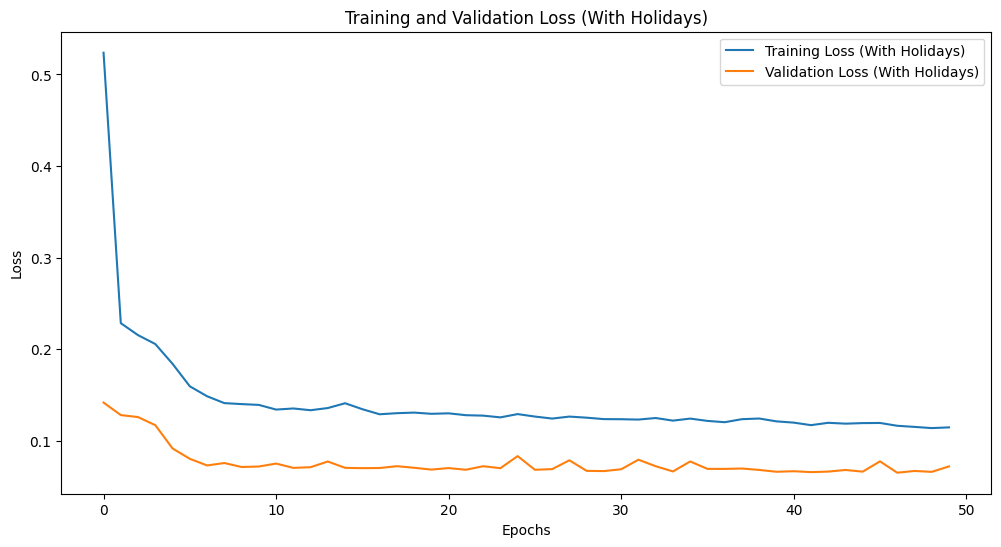

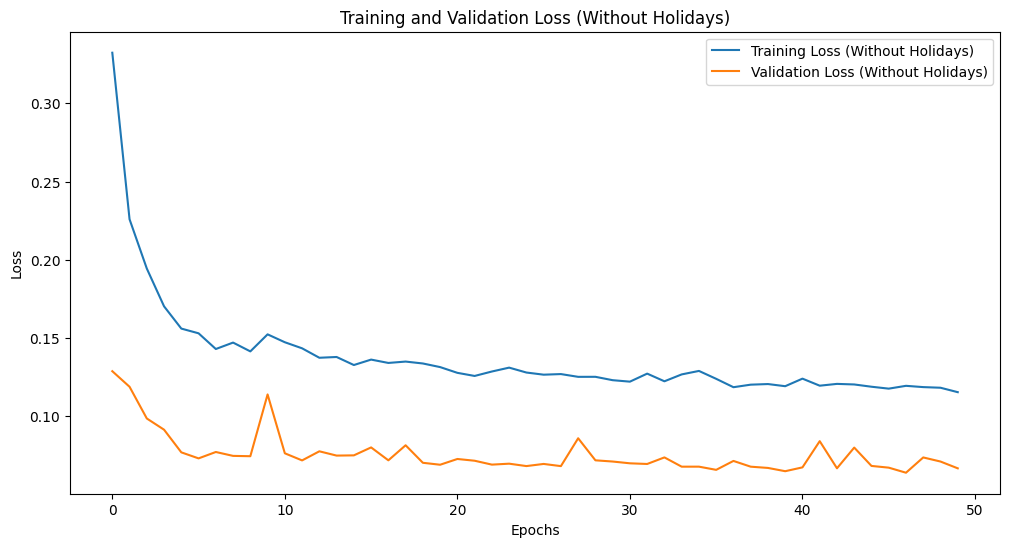

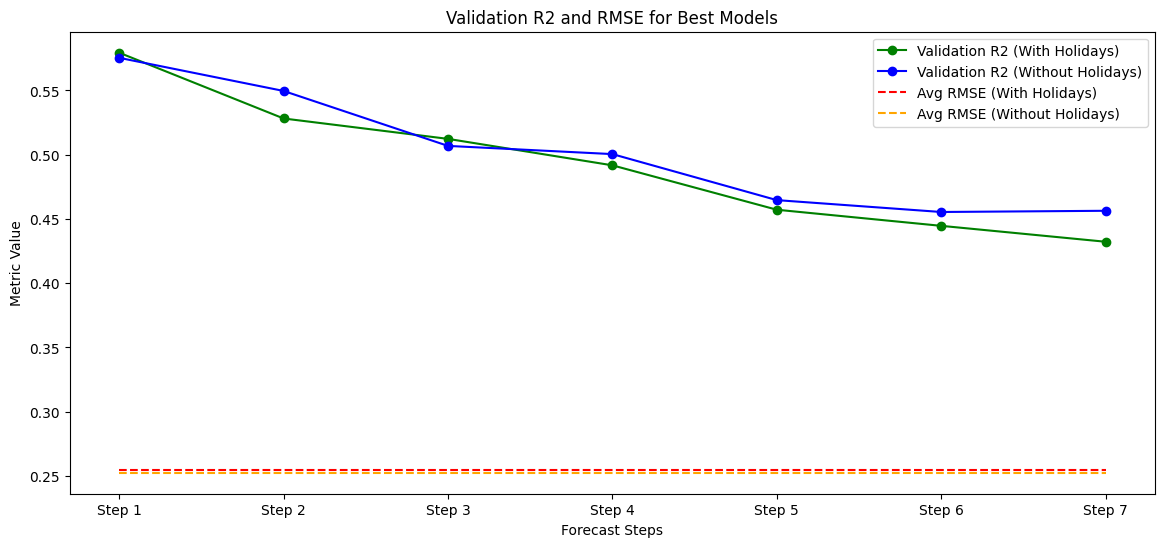

In [24]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
import holidays

# Load Data
data_path = '/kaggle/input/electricity-dataset-forecasting/household_power_consumption.txt'
data = pd.read_csv(data_path, sep=';', header=0, low_memory=False)

# Handle datetime columns properly
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(columns=['Date', 'Time'], inplace=True)
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Convert numeric columns to proper data types
numeric_cols = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')
data = data.interpolate()

# Aggregate minute-level data to daily level
data_daily = data.resample('D').mean()
data_daily.reset_index(inplace=True)
data_daily.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Feature Engineering
data_daily['day_of_week'] = data_daily['ds'].dt.day_name()
data_daily['is_friday'] = (data_daily['ds'].dt.dayofweek == 4).astype(int)
data_daily['is_monday'] = (data_daily['ds'].dt.dayofweek == 0).astype(int)
data_daily['is_weekend'] = (data_daily['ds'].dt.dayofweek >= 5).astype(int)

# Add in-built holidays for France
french_holidays = pd.to_datetime(list(holidays.FR(years=data_daily['ds'].dt.year.unique())), errors='coerce')
data_daily['is_holiday'] = data_daily['ds'].isin(french_holidays).astype(int)
data_daily['is_friday_and_holiday'] = (data_daily['is_friday'] & data_daily['is_holiday']).astype(int)
data_daily['is_monday_and_holiday'] = (data_daily['is_monday'] & data_daily['is_holiday']).astype(int)

# Adjusted split ranges based on the last date in the dataset
train = data_daily[(data_daily['ds'] >= '2006-12-16') & (data_daily['ds'] < '2009-11-01')]
val = data_daily[(data_daily['ds'] >= '2009-11-01') & (data_daily['ds'] < '2010-10-01')]
test = data_daily[(data_daily['ds'] >= '2010-10-01') & (data_daily['ds'] <= '2010-11-26')]

# Validate the test split
if len(test) < 30:
    print(f"Warning: Test data has only {len(test)} days. You may need to adjust the splits.")
else:
    print(f"Test data has {len(test)} days, suitable for evaluation.")

# Reframe data for multi-step forecasting
def to_supervised(data, n_input, n_output, features):
    X, y = [], []
    data_values = data[features].values
    for i in range(len(data_values) - n_input - n_output + 1):
        X.append(data_values[i:i + n_input])
        y.append(data_values[i + n_input:i + n_input + n_output, 0])
    return np.array(X), np.array(y)

# Define input and output window sizes
n_input = 30
n_output = 7

# Features for Experiment 1 (With Holidays)
features_with_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'is_holiday',
    'is_friday_and_holiday', 'is_monday_and_holiday', 'is_weekend',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
X_train_holidays, y_train_holidays = to_supervised(train, n_input, n_output, features_with_holidays)
X_val_holidays, y_val_holidays = to_supervised(val, n_input, n_output, features_with_holidays)

# Features for Experiment 2 (Without Holidays)
features_without_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
X_train_no_holidays, y_train_no_holidays = to_supervised(train, n_input, n_output, features_without_holidays)
X_val_no_holidays, y_val_no_holidays = to_supervised(val, n_input, n_output, features_without_holidays)

# Parameter grid for tuning
param_grid = {
    'lstm_units': [128, 256],  # Experiment with larger LSTM layers
    'dropout_rate': [0.2, 0.3, 0.4],  # Adjust dropout rate
    'learning_rate': [0.001, 0.0005],  # Learning rates for Adam optimizer
    'batch_size': [32, 64],  # Batch sizes
    'epochs': [50]  # Fixed epochs (early stopping will stop training earlier)
}

# Function to build and train the model
def train_lstm_with_params(X_train, y_train, X_val, y_val, params):
    lstm_units = params['lstm_units']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']

    # Build model
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_output))  # Multi-step output
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Train model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Predict validation set
    y_pred_val = model.predict(X_val)

    # Calculate metrics
    rmse_val = [np.sqrt(mean_squared_error(y_val[:, i], y_pred_val[:, i])) for i in range(n_output)]
    r2_val = [r2_score(y_val[:, i], y_pred_val[:, i]) for i in range(n_output)]

    return model, rmse_val, r2_val, history, y_pred_val

# Hyperparameter tuning loop
def tune_model(X_train, y_train, X_val, y_val, param_grid):
    best_model = None
    best_params = None
    best_rmse = float('inf')
    best_r2 = None
    results = []

    for params in ParameterGrid(param_grid):
        print(f"Training with params: {params}")
        model, rmse_val, r2_val, history, y_pred_val = train_lstm_with_params(
            X_train, y_train, X_val, y_val, params
        )

        avg_rmse = np.mean(rmse_val)
        results.append({'params': params, 'avg_rmse': avg_rmse, 'rmse_val': rmse_val, 'r2_val': r2_val})

        if avg_rmse < best_rmse:
            best_model = model
            best_params = params
            best_rmse = avg_rmse
            best_r2 = r2_val
            best_history = history

    return best_model, best_params, best_rmse, best_r2, best_history, results

# Tune for "With Holidays"
best_model_holidays, best_params_holidays, best_rmse_holidays, best_r2_holidays, best_history_holidays, results_holidays = tune_model(
    X_train_holidays, y_train_holidays, X_val_holidays, y_val_holidays, param_grid
)

# Tune for "Without Holidays"
best_model_no_holidays, best_params_no_holidays, best_rmse_no_holidays, best_r2_no_holidays, best_history_no_holidays, results_no_holidays = tune_model(
    X_train_no_holidays, y_train_no_holidays, X_val_no_holidays, y_val_no_holidays, param_grid
)

# Print best parameters and metrics for both experiments
print("Best Parameters (With Holidays):", best_params_holidays)
print("Best RMSE (With Holidays):", best_rmse_holidays)
print("Best R2 (With Holidays):", best_r2_holidays)

print("Best Parameters (Without Holidays):", best_params_no_holidays)
print("Best RMSE (Without Holidays):", best_rmse_no_holidays)
print("Best R2 (Without Holidays):", best_r2_no_holidays)

# Plot training and validation loss for "With Holidays"
plt.figure(figsize=(12, 6))
plt.plot(best_history_holidays.history['loss'], label='Training Loss (With Holidays)')
plt.plot(best_history_holidays.history['val_loss'], label='Validation Loss (With Holidays)')
plt.title('Training and Validation Loss (With Holidays)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation loss for "Without Holidays"
plt.figure(figsize=(12, 6))
plt.plot(best_history_no_holidays.history['loss'], label='Training Loss (Without Holidays)')
plt.plot(best_history_no_holidays.history['val_loss'], label='Validation Loss (Without Holidays)')
plt.title('Training and Validation Loss (Without Holidays)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize RMSE and R2 for each step in the forecast horizon for "With Holidays"
steps = [f"Step {i+1}" for i in range(n_output)]
plt.figure(figsize=(14, 6))
plt.plot(steps, best_r2_holidays, label='Validation R2 (With Holidays)', marker='o', color='green')
plt.plot(steps, best_r2_no_holidays, label='Validation R2 (Without Holidays)', marker='o', color='blue')
plt.plot(steps, [best_rmse_holidays] * len(steps), label='Avg RMSE (With Holidays)', linestyle='--', color='red')
plt.plot(steps, [best_rmse_no_holidays] * len(steps), label='Avg RMSE (Without Holidays)', linestyle='--', color='orange')
plt.title('Validation R2 and RMSE for Best Models')
plt.xlabel('Forecast Steps')
plt.ylabel('Metric Value')
plt.legend()
plt.show()


In [ ]:
**********************stacked LSTM****************************************************88

Test data has 57 days, suitable for evaluation.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.4955 - val_loss: 0.1284
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2152 - val_loss: 0.1230
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1941 - val_loss: 0.1068
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1819 - val_loss: 0.0905
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1534 - val_loss: 0.0806
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1501 - val_loss: 0.0731
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1369 - val_loss: 0.0895
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1372 - val_loss: 0.0726
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1299 - val_loss: 0.0731
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1379 - val_loss: 0.0742
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1384 - val_loss: 0.0743
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1309 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.4196 - val_loss: 0.1423
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2053 - val_loss: 0.1313
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1861 - val_loss: 0.1074
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1678 - val_loss: 0.0861
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1497 - val_loss: 0.0773
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1314 - val_loss: 0.0748
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1376 - val_loss: 0.0885
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1381 - val_loss: 0.0825
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1438 - val_loss: 0.0762
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1436 - val_loss: 0.0772
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1363 - val_loss: 0.0771
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1207 - val_loss: 0.0768

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4763 - val_loss: 0.1329
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2057 - val_loss: 0.1247
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2011 - val_loss: 0.1104
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1714 - val_loss: 0.1098
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1603 - val_loss: 0.0924
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1482 - val_loss: 0.0801
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1560 - val_loss: 0.0760
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1334 - val_loss: 0.0763
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1439 - val_loss: 0.0751
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1268 - val_loss: 0.0755
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1442 - val_loss: 0.0726
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1269 - val_loss: 0.0746

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4372 - val_loss: 0.1296
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1959 - val_loss: 0.1302
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2052 - val_loss: 0.1116
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1830 - val_loss: 0.0944
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1514 - val_loss: 0.0787
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1505 - val_loss: 0.0874
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1404 - val_loss: 0.0819
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1357 - val_loss: 0.0892
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1340 - val_loss: 0.0732
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1330 - val_loss: 0.0767
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1263 - val_loss: 0.0816
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1380 - val_loss: 0.0835

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4440 - val_loss: 0.1315
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2239 - val_loss: 0.1300
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2113 - val_loss: 0.1139
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1821 - val_loss: 0.1071
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1605 - val_loss: 0.0763
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1548 - val_loss: 0.0761
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1622 - val_loss: 0.0996
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1542 - val_loss: 0.0771
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1509 - val_loss: 0.0784
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1375 - val_loss: 0.0785
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1451 - val_loss: 0.0737
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1399 - val_loss: 0.0798

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3441 - val_loss: 0.1296
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2088 - val_loss: 0.1247
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1902 - val_loss: 0.0946
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1714 - val_loss: 0.0923
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1475 - val_loss: 0.0806
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1404 - val_loss: 0.0799
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1441 - val_loss: 0.0821
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1357 - val_loss: 0.0752
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1359 - val_loss: 0.0747
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1304 - val_loss: 0.0880
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1382 - val_loss: 0.0773
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1393 - val_loss: 0.0764

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5827 - val_loss: 0.1354
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2444 - val_loss: 0.1265
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2250 - val_loss: 0.1180
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2151 - val_loss: 0.1016
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1840 - val_loss: 0.0810
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1627 - val_loss: 0.0779
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1578 - val_loss: 0.0898
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1533 - val_loss: 0.0958
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1509 - val_loss: 0.0743
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1522 - val_loss: 0.0766
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1448 - val_loss: 0.0813
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1426 - val_loss: 0.0765

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.5154 - val_loss: 0.1423
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2376 - val_loss: 0.1283
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2045 - val_loss: 0.1168
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1867 - val_loss: 0.0850
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1566 - val_loss: 0.0761
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1364 - val_loss: 0.0822
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1441 - val_loss: 0.0757
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1323 - val_loss: 0.0787
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1413 - val_loss: 0.0758
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1511 - val_loss: 0.0913
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1401 - val_loss: 0.0758
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1387 - val_loss: 0.0905

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.5354 - val_loss: 0.1476
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2238 - val_loss: 0.1299
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2205 - val_loss: 0.1273
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1918 - val_loss: 0.1224
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1901 - val_loss: 0.1068
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1746 - val_loss: 0.0998
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1605 - val_loss: 0.0817
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1474 - val_loss: 0.0774
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1492 - val_loss: 0.0765
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1393 - val_loss: 0.0961
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1445 - val_loss: 0.0756
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1448 - val_loss: 0.07

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4856 - val_loss: 0.1308
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2081 - val_loss: 0.1300
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2027 - val_loss: 0.1262
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1941 - val_loss: 0.1274
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1900 - val_loss: 0.1138
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1652 - val_loss: 0.1062
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1551 - val_loss: 0.0771
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1353 - val_loss: 0.0749
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1309 - val_loss: 0.0910
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1307 - val_loss: 0.0766
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1351 - val_loss: 0.0736
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1358 - val_lo

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8389 - val_loss: 0.1737
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2582 - val_loss: 0.1342
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2193 - val_loss: 0.1263
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2024 - val_loss: 0.1223
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2104 - val_loss: 0.1174
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2023 - val_loss: 0.1092
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1838 - val_loss: 0.0951
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1763 - val_loss: 0.0881
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1621 - val_loss: 0.0938
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1530 - val_loss: 0.0774
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1441 - val_loss: 0.0803
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1404 - val_loss: 0.076

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.6028 - val_loss: 0.1613
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2241 - val_loss: 0.1329
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2156 - val_loss: 0.1254
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2000 - val_loss: 0.1236
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2000 - val_loss: 0.1183
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1809 - val_loss: 0.1111
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1718 - val_loss: 0.0998
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1454 - val_loss: 0.1001
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1455 - val_loss: 0.0946
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1427 - val_loss: 0.0743
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1513 - val_loss: 0.0753
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1393 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.7388 - val_loss: 0.1421
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2602 - val_loss: 0.1301
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2413 - val_loss: 0.1273
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2178 - val_loss: 0.1238
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2082 - val_loss: 0.1190
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2013 - val_loss: 0.1128
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1963 - val_loss: 0.0955
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1697 - val_loss: 0.0802
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1603 - val_loss: 0.0761
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1518 - val_loss: 0.0754
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1595 - val_loss: 0.0774
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1420 - val_loss: 0.0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.5277 - val_loss: 0.1292
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2194 - val_loss: 0.1301
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2036 - val_loss: 0.1271
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2058 - val_loss: 0.1194
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1952 - val_loss: 0.1028
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1656 - val_loss: 0.0819
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1550 - val_loss: 0.0910
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1373 - val_loss: 0.0812
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1408 - val_loss: 0.0838
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1406 - val_loss: 0.1072
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1365 - val_loss: 0.0756
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1384 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7225 - val_loss: 0.1765
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2609 - val_loss: 0.1367
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2384 - val_loss: 0.1222
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2313 - val_loss: 0.1183
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2071 - val_loss: 0.1113
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2069 - val_loss: 0.1006
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1909 - val_loss: 0.0832
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1668 - val_loss: 0.0884
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1663 - val_loss: 0.0834
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1656 - val_loss: 0.0790
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1544 - val_loss: 0.0778
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1466 - val_loss: 0.082

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.6046 - val_loss: 0.1559
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2311 - val_loss: 0.1350
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2035 - val_loss: 0.1285
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2060 - val_loss: 0.1254
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2051 - val_loss: 0.1229
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1869 - val_loss: 0.1133
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1914 - val_loss: 0.1016
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1725 - val_loss: 0.0898
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1616 - val_loss: 0.0768
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1412 - val_loss: 0.0833
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1403 - val_loss: 0.0747
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1460 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4148 - val_loss: 0.1300
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2137 - val_loss: 0.1211
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1981 - val_loss: 0.1026
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1633 - val_loss: 0.0770
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1448 - val_loss: 0.0780
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1507 - val_loss: 0.0768
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1418 - val_loss: 0.0768
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1365 - val_loss: 0.0779
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1314 - val_loss: 0.0744
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1300 - val_loss: 0.0743
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1406 - val_loss: 0.0814
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1358 - val_loss: 0.0758

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.4416 - val_loss: 0.1303
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1959 - val_loss: 0.1169
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1710 - val_loss: 0.1041
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1489 - val_loss: 0.0804
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1387 - val_loss: 0.0767
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1441 - val_loss: 0.0784
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1346 - val_loss: 0.0836
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1380 - val_loss: 0.0790
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1266 - val_loss: 0.0711
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1307 - val_loss: 0.0930
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1308 - val_loss: 0.0780
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1294 - val_loss: 0.0738

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.5473 - val_loss: 0.1293
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2056 - val_loss: 0.1118
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1879 - val_loss: 0.1063
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1653 - val_loss: 0.0989
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1518 - val_loss: 0.1041
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1671 - val_loss: 0.0993
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1456 - val_loss: 0.0801
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1509 - val_loss: 0.0744
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1428 - val_loss: 0.0753
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1384 - val_loss: 0.0876
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1517 - val_loss: 0.0905
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1454 - val_loss: 0.0764

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3701 - val_loss: 0.1383
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2072 - val_loss: 0.1274
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1887 - val_loss: 0.1195
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1755 - val_loss: 0.0924
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1405 - val_loss: 0.0950
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1453 - val_loss: 0.0883
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1347 - val_loss: 0.0767
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1344 - val_loss: 0.0761
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1307 - val_loss: 0.0746
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1280 - val_loss: 0.0800
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1296 - val_loss: 0.0960
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1364 - val_loss: 0.0765

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.4789 - val_loss: 0.1256
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2138 - val_loss: 0.1078
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1847 - val_loss: 0.0846
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1602 - val_loss: 0.0863
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1492 - val_loss: 0.0735
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1480 - val_loss: 0.0798
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1490 - val_loss: 0.0892
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1454 - val_loss: 0.0751
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1347 - val_loss: 0.0938
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1410 - val_loss: 0.0733
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1478 - val_loss: 0.0731
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1429 - val_loss: 0.0779

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.3426 - val_loss: 0.1308
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2022 - val_loss: 0.1203
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1875 - val_loss: 0.0813
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1490 - val_loss: 0.0987
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1589 - val_loss: 0.0739
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1387 - val_loss: 0.0797
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1396 - val_loss: 0.0735
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1313 - val_loss: 0.0772
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1311 - val_loss: 0.0724
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1346 - val_loss: 0.0755
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1346 - val_loss: 0.1048
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1430 - val_loss: 0.0769

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.6097 - val_loss: 0.1384
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2403 - val_loss: 0.1268
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2271 - val_loss: 0.1193
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2040 - val_loss: 0.1064
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1774 - val_loss: 0.1232
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1837 - val_loss: 0.1101
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1566 - val_loss: 0.0824
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1424 - val_loss: 0.0777
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1455 - val_loss: 0.0778
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1438 - val_loss: 0.0747
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1503 - val_loss: 0.0761
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1373 - val_loss: 0.0797

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.4505 - val_loss: 0.1267
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2147 - val_loss: 0.1141
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1822 - val_loss: 0.0883
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1539 - val_loss: 0.0772
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1478 - val_loss: 0.0807
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1396 - val_loss: 0.0939
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1356 - val_loss: 0.0747
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1465 - val_loss: 0.0916
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1501 - val_loss: 0.0907
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1341 - val_loss: 0.0737
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1417 - val_loss: 0.0936
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1370 - val_loss: 0.0729

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.8580 - val_loss: 0.1318
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2317 - val_loss: 0.1292
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2140 - val_loss: 0.1254
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2046 - val_loss: 0.1157
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1856 - val_loss: 0.1002
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1700 - val_loss: 0.0811
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1625 - val_loss: 0.0770
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1492 - val_loss: 0.0757
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1451 - val_loss: 0.0811
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1492 - val_loss: 0.0833
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1391 - val_loss: 0.0934
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1436 - val_loss: 0.08

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.5841 - val_loss: 0.1259
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2023 - val_loss: 0.1150
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1934 - val_loss: 0.1229
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1849 - val_loss: 0.1156
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1770 - val_loss: 0.0883
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1518 - val_loss: 0.0861
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1472 - val_loss: 0.0743
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1379 - val_loss: 0.1027
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1400 - val_loss: 0.0733
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1341 - val_loss: 0.0737
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1372 - val_loss: 0.0721
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1304 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.7078 - val_loss: 0.1536
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2315 - val_loss: 0.1343
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2109 - val_loss: 0.1240
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2045 - val_loss: 0.1200
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1968 - val_loss: 0.1106
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1797 - val_loss: 0.0949
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1636 - val_loss: 0.0896
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1593 - val_loss: 0.0906
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1485 - val_loss: 0.0837
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1546 - val_loss: 0.0851
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1390 - val_loss: 0.0816
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1467 - val_loss: 0.09

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.6488 - val_loss: 0.1494
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2196 - val_loss: 0.1333
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2001 - val_loss: 0.1259
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1860 - val_loss: 0.1219
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1922 - val_loss: 0.1094
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1726 - val_loss: 0.0888
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1572 - val_loss: 0.0815
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1595 - val_loss: 0.0788
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1386 - val_loss: 0.0834
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1352 - val_loss: 0.0862
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1418 - val_loss: 0.0880
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1310 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.5831 - val_loss: 0.1335
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2406 - val_loss: 0.1254
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2192 - val_loss: 0.1208
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2136 - val_loss: 0.1137
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1909 - val_loss: 0.0914
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1737 - val_loss: 0.0800
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1620 - val_loss: 0.0972
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1572 - val_loss: 0.0839
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1507 - val_loss: 0.0802
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1443 - val_loss: 0.0804
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1486 - val_loss: 0.1054
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1476 - val_loss: 0.08

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.5863 - val_loss: 0.1274
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2170 - val_loss: 0.1310
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2066 - val_loss: 0.1288
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2039 - val_loss: 0.1201
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2000 - val_loss: 0.1075
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1704 - val_loss: 0.1381
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1773 - val_loss: 0.0905
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1529 - val_loss: 0.0875
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1462 - val_loss: 0.0843
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1449 - val_loss: 0.0801
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1408 - val_loss: 0.0835
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1463 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.7625 - val_loss: 0.1729
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2754 - val_loss: 0.1342
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2421 - val_loss: 0.1226
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2230 - val_loss: 0.1108
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1970 - val_loss: 0.0893
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1731 - val_loss: 0.0761
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1678 - val_loss: 0.0778
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1545 - val_loss: 0.0726
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1533 - val_loss: 0.0734
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1584 - val_loss: 0.0765
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1431 - val_loss: 0.0771
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1499 - val_loss: 0.072

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.6498 - val_loss: 0.1491
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2444 - val_loss: 0.1339
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2127 - val_loss: 0.1276
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2093 - val_loss: 0.1234
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1980 - val_loss: 0.1135
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1823 - val_loss: 0.0846
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1637 - val_loss: 0.0810
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1582 - val_loss: 0.0810
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1577 - val_loss: 0.0897
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1459 - val_loss: 0.0830
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1455 - val_loss: 0.0825
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1338 - val_l

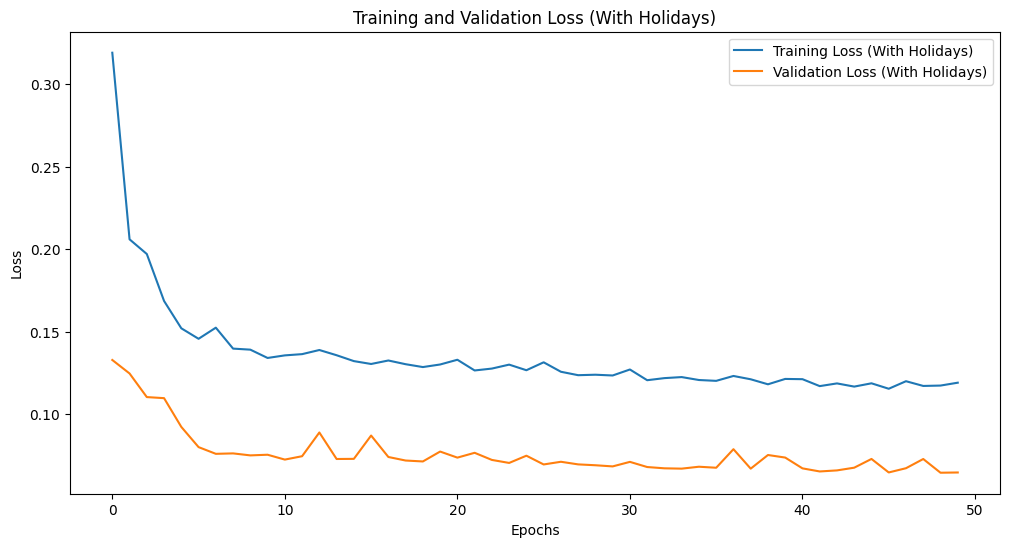

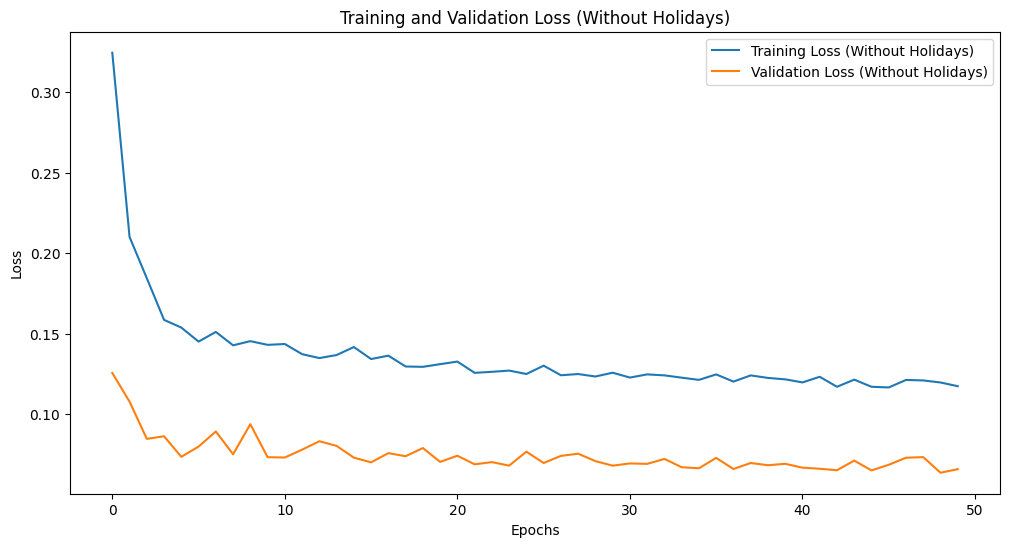

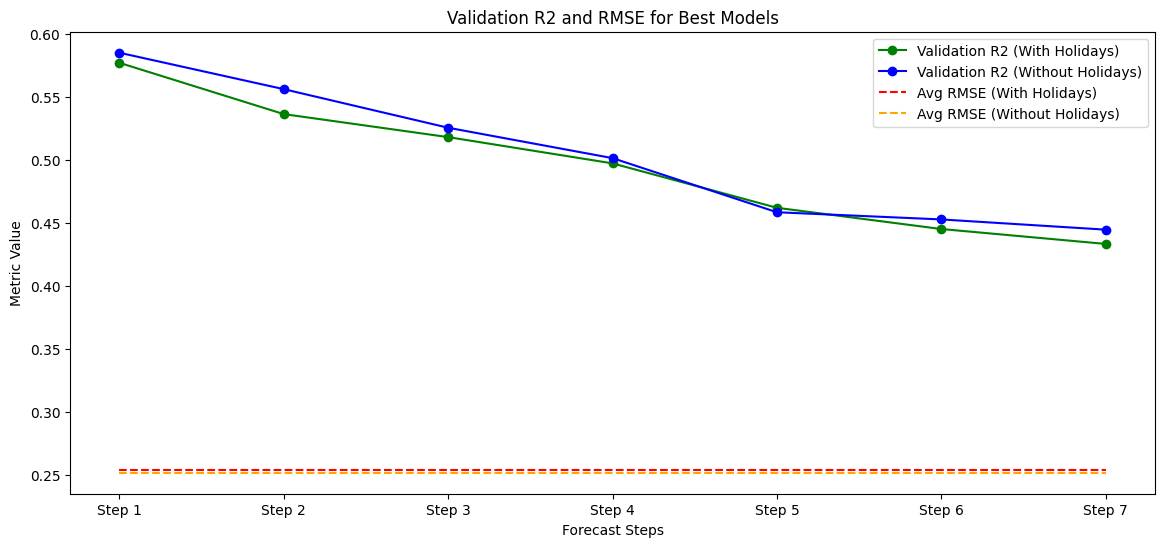

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
import holidays

# Load Data
data_path = '/kaggle/input/electricity-dataset-forecasting/household_power_consumption.txt'
data = pd.read_csv(data_path, sep=';', header=0, low_memory=False)

# Replace "?" with NaN
data.replace('?', np.nan, inplace=True)

# Handle datetime columns properly
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(columns=['Date', 'Time'], inplace=True)
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Convert numeric columns to proper data types
numeric_cols = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Impute Missing Values
data = data.interpolate(method='time')  # Time-based interpolation for numeric values
data.dropna(inplace=True)  # Drop any remaining rows with missing values

# Aggregate minute-level data to daily level
data_daily = data.resample('D').mean()
data_daily.reset_index(inplace=True)
data_daily.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Feature Engineering
data_daily['day_of_week'] = data_daily['ds'].dt.dayofweek  # Numeric day of week (0=Monday, 6=Sunday)
data_daily['is_weekend'] = (data_daily['day_of_week'] >= 5).astype(int)
data_daily['is_holiday'] = data_daily['ds'].isin(pd.to_datetime(list(holidays.FR(years=data_daily['ds'].dt.year.unique())), errors='coerce')).astype(int)
data_daily['is_friday_and_holiday'] = ((data_daily['day_of_week'] == 4) & (data_daily['is_holiday'] == 1)).astype(int)
data_daily['is_monday_and_holiday'] = ((data_daily['day_of_week'] == 0) & (data_daily['is_holiday'] == 1)).astype(int)

# Adjusted split ranges based on the last date in the dataset
train = data_daily[(data_daily['ds'] >= '2006-12-16') & (data_daily['ds'] < '2009-11-01')]
val = data_daily[(data_daily['ds'] >= '2009-11-01') & (data_daily['ds'] < '2010-10-01')]
test = data_daily[(data_daily['ds'] >= '2010-10-01') & (data_daily['ds'] <= '2010-11-26')]

# Validate the test split
if len(test) < 30:
    print(f"Warning: Test data has only {len(test)} days. You may need to adjust the splits.")
else:
    print(f"Test data has {len(test)} days, suitable for evaluation.")

# Reframe data for multi-step forecasting
def to_supervised(data, n_input, n_output, features):
    X, y = [], []
    data_values = data[features].values
    for i in range(len(data_values) - n_input - n_output + 1):
        X.append(data_values[i:i + n_input])
        y.append(data_values[i + n_input:i + n_input + n_output, 0])
    return np.array(X), np.array(y)

# Define input and output window sizes
n_input = 30
n_output = 7

# Features for Experiment (With and Without Holidays)
features_with_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'is_weekend', 'is_holiday', 'is_friday_and_holiday', 'is_monday_and_holiday'
]
features_without_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

X_train_holidays, y_train_holidays = to_supervised(train, n_input, n_output, features_with_holidays)
X_val_holidays, y_val_holidays = to_supervised(val, n_input, n_output, features_with_holidays)

X_train_no_holidays, y_train_no_holidays = to_supervised(train, n_input, n_output, features_without_holidays)
X_val_no_holidays, y_val_no_holidays = to_supervised(val, n_input, n_output, features_without_holidays)

# Improved Hyperparameter Grid
param_grid = {
    'lstm_units': [128, 256],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64],
    'epochs': [50]
}

# Function to build stacked LSTM model
def build_stacked_lstm(lstm_units, dropout_rate, learning_rate, n_input, n_output):
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(n_input, X_train_holidays.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_output))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function to tune model
def tune_model(X_train, y_train, X_val, y_val, param_grid):
    best_model, best_params, best_rmse, best_r2, best_history = None, None, float('inf'), None, None
    for params in ParameterGrid(param_grid):
        model = build_stacked_lstm(
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            n_input=n_input,
            n_output=n_output
        )

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(
            X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
            validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping]
        )

        y_pred_val = model.predict(X_val)
        rmse_val = [np.sqrt(mean_squared_error(y_val[:, i], y_pred_val[:, i])) for i in range(n_output)]
        r2_val = [r2_score(y_val[:, i], y_pred_val[:, i]) for i in range(n_output)]

        if np.mean(rmse_val) < best_rmse:
            best_model, best_params, best_rmse, best_r2, best_history = model, params, np.mean(rmse_val), r2_val, history

    return best_model, best_params, best_rmse, best_r2, best_history

# Tune for "With Holidays"
best_model_holidays, best_params_holidays, best_rmse_holidays, best_r2_holidays, best_history_holidays = tune_model(
    X_train_holidays, y_train_holidays, X_val_holidays, y_val_holidays, param_grid
)

# Tune for "Without Holidays"
best_model_no_holidays, best_params_no_holidays, best_rmse_no_holidays, best_r2_no_holidays, best_history_no_holidays = tune_model(
    X_train_no_holidays, y_train_no_holidays, X_val_no_holidays, y_val_no_holidays, param_grid
)

# Print best parameters and metrics for both experiments
print("Best Parameters (With Holidays):", best_params_holidays)
print("Best RMSE (With Holidays):", best_rmse_holidays)
print("Best R2 (With Holidays):", best_r2_holidays)

print("Best Parameters (Without Holidays):", best_params_no_holidays)
print("Best RMSE (Without Holidays):", best_rmse_no_holidays)
print("Best R2 (Without Holidays):", best_r2_no_holidays)

# Plot training and validation loss for "With Holidays"
plt.figure(figsize=(12, 6))
plt.plot(best_history_holidays.history['loss'], label='Training Loss (With Holidays)')
plt.plot(best_history_holidays.history['val_loss'], label='Validation Loss (With Holidays)')
plt.title('Training and Validation Loss (With Holidays)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation loss for "Without Holidays"
plt.figure(figsize=(12, 6))
plt.plot(best_history_no_holidays.history['loss'], label='Training Loss (Without Holidays)')
plt.plot(best_history_no_holidays.history['val_loss'], label='Validation Loss (Without Holidays)')
plt.title('Training and Validation Loss (Without Holidays)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize RMSE and R2 for each step in the forecast horizon for "With Holidays"
steps = [f"Step {i+1}" for i in range(n_output)]
plt.figure(figsize=(14, 6))
plt.plot(steps, best_r2_holidays, label='Validation R2 (With Holidays)', marker='o', color='green')
plt.plot(steps, best_r2_no_holidays, label='Validation R2 (Without Holidays)', marker='o', color='blue')
plt.plot(steps, [best_rmse_holidays] * len(steps), label='Avg RMSE (With Holidays)', linestyle='--', color='red')
plt.plot(steps, [best_rmse_no_holidays] * len(steps), label='Avg RMSE (Without Holidays)', linestyle='--', color='orange')
plt.title('Validation R2 and RMSE for Best Models')
plt.xlabel('Forecast Steps')
plt.ylabel('Metric Value')
plt.legend()
plt.show()




In [ ]:
******bidirectional LSTM **************************

Test data has 57 days, suitable for evaluation.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.5155 - val_loss: 0.1302
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2180 - val_loss: 0.1220
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2093 - val_loss: 0.1023
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1680 - val_loss: 0.0785
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1601 - val_loss: 0.0762
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1504 - val_loss: 0.0889
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1424 - val_loss: 0.0758
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1355 - val_loss: 0.0789
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1429 - val_loss: 0.0782
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1428 - val_loss: 0.0739
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1434 - val_loss: 0.0744
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1415 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.5025 - val_loss: 0.1335
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2009 - val_loss: 0.1217
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1931 - val_loss: 0.0959
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1623 - val_loss: 0.0820
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1495 - val_loss: 0.0762
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1355 - val_loss: 0.0757
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1338 - val_loss: 0.0786
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1317 - val_loss: 0.0734
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1331 - val_loss: 0.0798
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1344 - val_loss: 0.0734
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1372 - val_loss: 0.0733
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1291 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7501 - val_loss: 0.1402
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2308 - val_loss: 0.1244
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2125 - val_loss: 0.1151
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2020 - val_loss: 0.0928
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1706 - val_loss: 0.0850
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1652 - val_loss: 0.0856
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1539 - val_loss: 0.0753
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1454 - val_loss: 0.0757
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1470 - val_loss: 0.0762
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1373 - val_loss: 0.0776
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1350 - val_loss: 0.0877
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1339 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4477 - val_loss: 0.1331
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2192 - val_loss: 0.1232
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1840 - val_loss: 0.1024
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1615 - val_loss: 0.0945
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1464 - val_loss: 0.0958
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1365 - val_loss: 0.0753
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1387 - val_loss: 0.0759
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1395 - val_loss: 0.0778
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1338 - val_loss: 0.0842
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1342 - val_loss: 0.0858
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1344 - val_loss: 0.0898
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1410 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.7037 - val_loss: 0.1327
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2306 - val_loss: 0.1303
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2220 - val_loss: 0.1272
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2095 - val_loss: 0.1076
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1855 - val_loss: 0.0867
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1744 - val_loss: 0.0861
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1502 - val_loss: 0.0805
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1621 - val_loss: 0.0882
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1495 - val_loss: 0.0933
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1449 - val_loss: 0.0843
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1393 - val_loss: 0.0863
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1449 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.3817 - val_loss: 0.1356
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2130 - val_loss: 0.1197
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1701 - val_loss: 0.0962
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1702 - val_loss: 0.0824
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1538 - val_loss: 0.1076
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1557 - val_loss: 0.0857
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1429 - val_loss: 0.0807
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1378 - val_loss: 0.0753
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1419 - val_loss: 0.0803
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1348 - val_loss: 0.0811
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1399 - val_loss: 0.0905
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1374 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.7708 - val_loss: 0.1305
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2452 - val_loss: 0.1304
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2345 - val_loss: 0.1338
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2250 - val_loss: 0.1199
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2057 - val_loss: 0.1149
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1886 - val_loss: 0.0947
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1831 - val_loss: 0.0821
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1653 - val_loss: 0.0888
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1614 - val_loss: 0.1030
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1541 - val_loss: 0.0769
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1498 - val_loss: 0.0811
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1500 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.5662 - val_loss: 0.1311
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2269 - val_loss: 0.1261
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2067 - val_loss: 0.1175
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1942 - val_loss: 0.0844
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1722 - val_loss: 0.1091
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1542 - val_loss: 0.0802
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1612 - val_loss: 0.0763
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1480 - val_loss: 0.0753
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1412 - val_loss: 0.0859
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1476 - val_loss: 0.1143
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1397 - val_loss: 0.0771
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1461 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.7401 - val_loss: 0.1472
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2340 - val_loss: 0.1324
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2172 - val_loss: 0.1274
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2133 - val_loss: 0.1234
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2044 - val_loss: 0.1170
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1919 - val_loss: 0.1103
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1876 - val_loss: 0.1021
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1759 - val_loss: 0.0812
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1553 - val_loss: 0.0989
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1484 - val_loss: 0.0813
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1508 - val_loss: 0.0754
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1433 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.4918 - val_loss: 0.1498
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2188 - val_loss: 0.1284
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2025 - val_loss: 0.1280
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1995 - val_loss: 0.1223
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1935 - val_loss: 0.1094
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1671 - val_loss: 0.0913
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1702 - val_loss: 0.0953
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1428 - val_loss: 0.0785
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1397 - val_loss: 0.0862
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1388 - val_loss: 0.0896
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1367 - val_loss: 0.0753
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1347 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.6600 - val_loss: 0.1731
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2663 - val_loss: 0.1284
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2252 - val_loss: 0.1275
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2128 - val_loss: 0.1237
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2134 - val_loss: 0.1277
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2031 - val_loss: 0.1211
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1966 - val_loss: 0.1177
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1808 - val_loss: 0.0877
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1642 - val_loss: 0.0884
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1517 - val_loss: 0.0880
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1476 - val_loss: 0.0919
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1527 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.6277 - val_loss: 0.1406
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2367 - val_loss: 0.1329
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2165 - val_loss: 0.1284
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2133 - val_loss: 0.1254
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1975 - val_loss: 0.1199
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2000 - val_loss: 0.1183
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1794 - val_loss: 0.1023
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1593 - val_loss: 0.0938
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1535 - val_loss: 0.1198
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1544 - val_loss: 0.0741
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1396 - val_loss: 0.0753
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1399 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.7379 - val_loss: 0.1401
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2586 - val_loss: 0.1285
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2396 - val_loss: 0.1266
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2280 - val_loss: 0.1252
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2222 - val_loss: 0.1132
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2086 - val_loss: 0.1097
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1955 - val_loss: 0.0892
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1722 - val_loss: 0.1035
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1620 - val_loss: 0.0826
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1547 - val_loss: 0.0769
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1514 - val_loss: 0.0859
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1546 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.6938 - val_loss: 0.1554
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2198 - val_loss: 0.1342
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2198 - val_loss: 0.1255
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2049 - val_loss: 0.1202
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2020 - val_loss: 0.1063
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1763 - val_loss: 0.0845
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1687 - val_loss: 0.0825
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1526 - val_loss: 0.0783
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1549 - val_loss: 0.0791
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1434 - val_loss: 0.0739
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1503 - val_loss: 0.0752
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1350 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.7575 - val_loss: 0.1718
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2689 - val_loss: 0.1307
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2711 - val_loss: 0.1277
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2409 - val_loss: 0.1272
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2282 - val_loss: 0.1267
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2301 - val_loss: 0.1224
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2201 - val_loss: 0.1196
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2158 - val_loss: 0.1148
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2061 - val_loss: 0.1069
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1929 - val_loss: 0.1044
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1901 - val_loss: 0.0863
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1751 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.6984 - val_loss: 0.1298
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2493 - val_loss: 0.1264
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2237 - val_loss: 0.1235
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2141 - val_loss: 0.1211
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2055 - val_loss: 0.1123
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1979 - val_loss: 0.1103
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1798 - val_loss: 0.0899
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1585 - val_loss: 0.1059
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1562 - val_loss: 0.1047
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1487 - val_loss: 0.0943
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1505 - val_loss: 0.0821
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1368 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.4584 - val_loss: 0.1329
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2103 - val_loss: 0.1153
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1904 - val_loss: 0.0918
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1550 - val_loss: 0.0862
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1483 - val_loss: 0.0800
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1449 - val_loss: 0.0869
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1350 - val_loss: 0.0763
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1351 - val_loss: 0.1093
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1456 - val_loss: 0.0818
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1429 - val_loss: 0.0790
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1363 - val_loss: 0.0840
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1375 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.4139 - val_loss: 0.1299
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2126 - val_loss: 0.1237
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1974 - val_loss: 0.0945
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1527 - val_loss: 0.0912
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1360 - val_loss: 0.0816
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1371 - val_loss: 0.0838
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1319 - val_loss: 0.0738
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1395 - val_loss: 0.1246
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1358 - val_loss: 0.0756
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1298 - val_loss: 0.0811
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1325 - val_loss: 0.0953
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1326 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.5896 - val_loss: 0.1315
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2170 - val_loss: 0.1272
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2102 - val_loss: 0.1184
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2088 - val_loss: 0.1022
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1824 - val_loss: 0.0942
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1672 - val_loss: 0.0811
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1624 - val_loss: 0.0805
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1506 - val_loss: 0.0832
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1498 - val_loss: 0.0822
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1346 - val_loss: 0.0831
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1388 - val_loss: 0.0757
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1425 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.4692 - val_loss: 0.1364
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2106 - val_loss: 0.1352
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2077 - val_loss: 0.1243
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1971 - val_loss: 0.1066
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1559 - val_loss: 0.0984
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1477 - val_loss: 0.0813
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1393 - val_loss: 0.0793
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1430 - val_loss: 0.0761
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1327 - val_loss: 0.0866
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1432 - val_loss: 0.1038
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1360 - val_loss: 0.0941
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1312 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.4388 - val_loss: 0.1291
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2165 - val_loss: 0.1123
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2043 - val_loss: 0.0853
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1670 - val_loss: 0.1006
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1593 - val_loss: 0.0958
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1511 - val_loss: 0.0807
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1501 - val_loss: 0.1135
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1598 - val_loss: 0.1040
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1516 - val_loss: 0.0867
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1310 - val_loss: 0.0753
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1415 - val_loss: 0.0886
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1411 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 0.5003 - val_loss: 0.1314
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2098 - val_loss: 0.1220
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2013 - val_loss: 0.0917
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1692 - val_loss: 0.0895
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1498 - val_loss: 0.0859
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1455 - val_loss: 0.0791
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1451 - val_loss: 0.0990
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1428 - val_loss: 0.0859
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1591 - val_loss: 0.0847
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1382 - val_loss: 0.0738
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1368 - val_loss: 0.0967
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1373 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.7507 - val_loss: 0.1331
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2655 - val_loss: 0.1316
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2441 - val_loss: 0.1253
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2186 - val_loss: 0.1105
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2046 - val_loss: 0.0958
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1933 - val_loss: 0.0856
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1758 - val_loss: 0.0788
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1553 - val_loss: 0.0878
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1601 - val_loss: 0.0817
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1529 - val_loss: 0.0709
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1510 - val_loss: 0.0750
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1504 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.5755 - val_loss: 0.1370
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2317 - val_loss: 0.1282
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2236 - val_loss: 0.1249
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2055 - val_loss: 0.1146
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1813 - val_loss: 0.0849
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1668 - val_loss: 0.0955
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1538 - val_loss: 0.0795
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1550 - val_loss: 0.0746
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1570 - val_loss: 0.0745
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1389 - val_loss: 0.0761
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1432 - val_loss: 0.0752
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1341 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.5207 - val_loss: 0.1283
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2264 - val_loss: 0.1132
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1946 - val_loss: 0.1013
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1778 - val_loss: 0.0974
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1746 - val_loss: 0.0993
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1650 - val_loss: 0.0960
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1595 - val_loss: 0.0827
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1576 - val_loss: 0.0906
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1437 - val_loss: 0.0785
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1458 - val_loss: 0.0812
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1487 - val_loss: 0.0823
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1432 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.5868 - val_loss: 0.1561
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2137 - val_loss: 0.1270
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2040 - val_loss: 0.1213
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1904 - val_loss: 0.1017
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1702 - val_loss: 0.0990
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1476 - val_loss: 0.0764
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1461 - val_loss: 0.0901
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1411 - val_loss: 0.0821
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1362 - val_loss: 0.0844
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1471 - val_loss: 0.0867
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1331 - val_loss: 0.0867
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1350 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.5814 - val_loss: 0.1729
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2419 - val_loss: 0.1305
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2215 - val_loss: 0.1281
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2085 - val_loss: 0.1271
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1999 - val_loss: 0.1248
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2126 - val_loss: 0.1151
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1848 - val_loss: 0.1036
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1751 - val_loss: 0.0888
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1647 - val_loss: 0.0843
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1665 - val_loss: 0.0916
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1487 - val_loss: 0.0781
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1482 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.5398 - val_loss: 0.1347
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2193 - val_loss: 0.1360
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2104 - val_loss: 0.1246
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1954 - val_loss: 0.1142
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1809 - val_loss: 0.1053
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1741 - val_loss: 0.0846
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1520 - val_loss: 0.0821
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1425 - val_loss: 0.0774
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1454 - val_loss: 0.0790
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1497 - val_loss: 0.0793
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1416 - val_loss: 0.0829
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1369 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.6702 - val_loss: 0.1381
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2593 - val_loss: 0.1301
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2383 - val_loss: 0.1229
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2153 - val_loss: 0.1219
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2167 - val_loss: 0.0986
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1838 - val_loss: 0.0845
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1692 - val_loss: 0.0909
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1670 - val_loss: 0.0887
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1515 - val_loss: 0.0950
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1591 - val_loss: 0.0764
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1551 - val_loss: 0.0768
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1567 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.7156 - val_loss: 0.1550
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2466 - val_loss: 0.1280
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2126 - val_loss: 0.1272
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2089 - val_loss: 0.1195
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2027 - val_loss: 0.1017
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1789 - val_loss: 0.1075
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1679 - val_loss: 0.0839
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1520 - val_loss: 0.0818
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1439 - val_loss: 0.0817
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1442 - val_loss: 0.0825
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1434 - val_loss: 0.1086
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1420 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 1.0894 - val_loss: 0.1304
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2881 - val_loss: 0.1241
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2391 - val_loss: 0.1177
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2213 - val_loss: 0.1104
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2102 - val_loss: 0.0931
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1920 - val_loss: 0.1005
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1854 - val_loss: 0.0841
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1775 - val_loss: 0.0917
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1650 - val_loss: 0.0899
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1679 - val_loss: 0.0802
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1592 - val_loss: 0.0780
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1565 - val_l

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.6553 - val_loss: 0.1360
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2549 - val_loss: 0.1326
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2317 - val_loss: 0.1294
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2181 - val_loss: 0.1303
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2287 - val_loss: 0.1262
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2026 - val_loss: 0.1266
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2033 - val_loss: 0.1150
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1923 - val_loss: 0.0921
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1707 - val_loss: 0.0790
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1533 - val_loss: 0.0774
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1561 - val_loss: 0.0771
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1455 - val_l

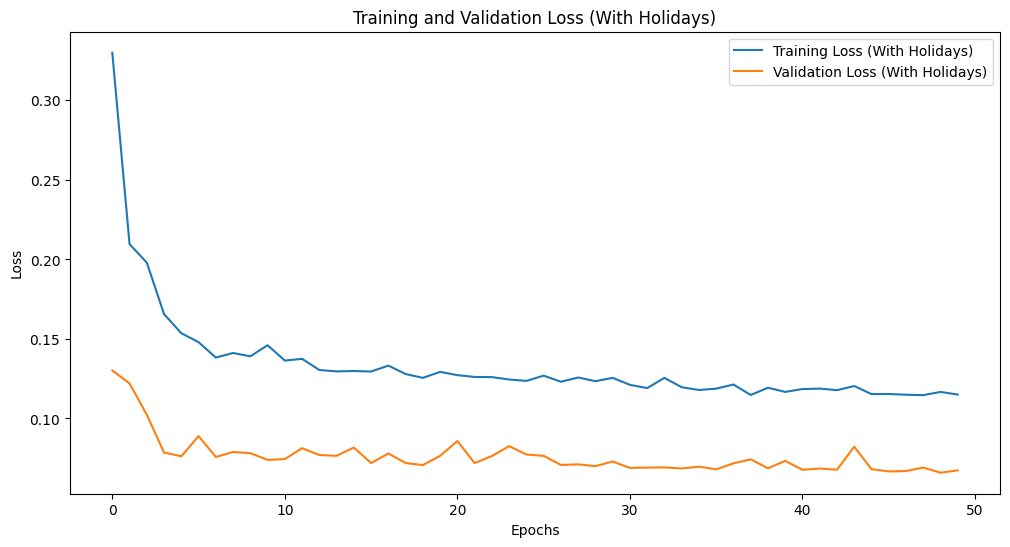

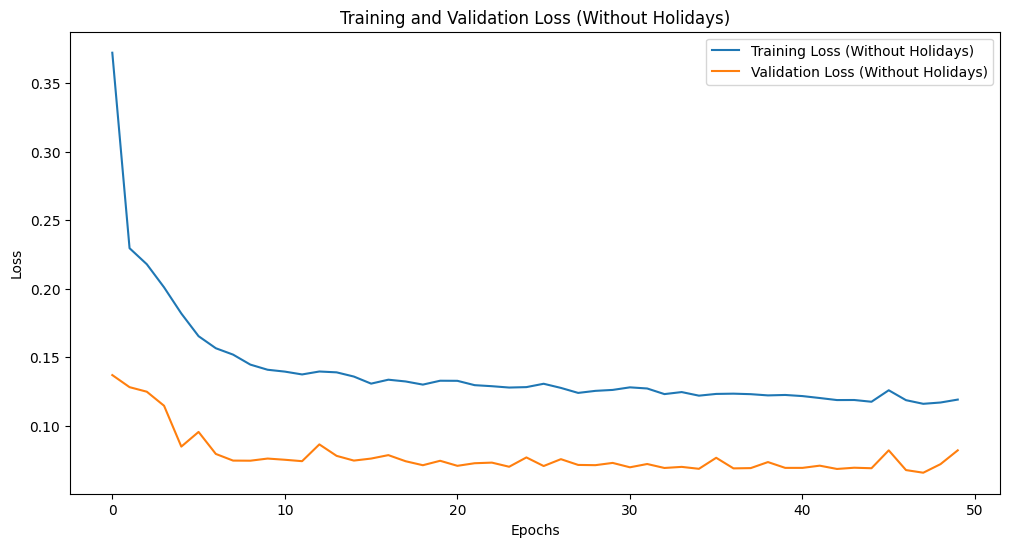

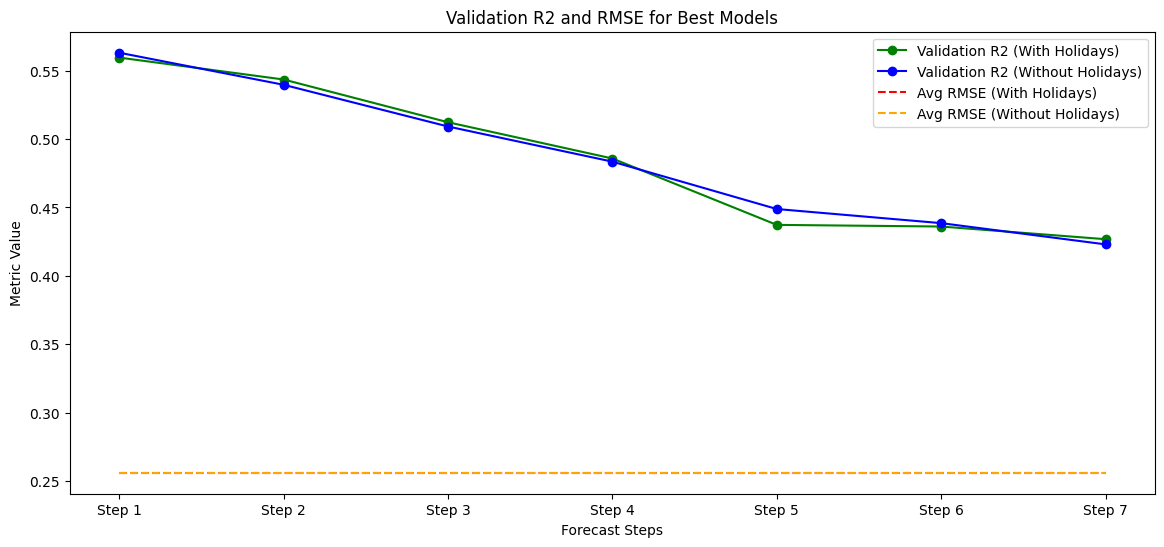

In [25]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ParameterGrid
import holidays

# Load Data
data_path = '/kaggle/input/electricity-dataset-forecasting/household_power_consumption.txt'
data = pd.read_csv(data_path, sep=';', header=0, low_memory=False)

# Replace "?" with NaN
data.replace('?', np.nan, inplace=True)

# Handle datetime columns properly
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(columns=['Date', 'Time'], inplace=True)
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Convert numeric columns to proper data types
numeric_cols = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Impute Missing Values
data = data.interpolate(method='time')
data.dropna(inplace=True)

# Aggregate minute-level data to daily level
data_daily = data.resample('D').mean()
data_daily.reset_index(inplace=True)
data_daily.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Feature Engineering
data_daily['day_of_week'] = data_daily['ds'].dt.dayofweek
data_daily['is_weekend'] = (data_daily['day_of_week'] >= 5).astype(int)
data_daily['is_holiday'] = data_daily['ds'].isin(
    pd.to_datetime(list(holidays.FR(years=data_daily['ds'].dt.year.unique())), errors='coerce')
).astype(int)
data_daily['is_friday_and_holiday'] = ((data_daily['day_of_week'] == 4) & (data_daily['is_holiday'] == 1)).astype(int)
data_daily['is_monday_and_holiday'] = ((data_daily['day_of_week'] == 0) & (data_daily['is_holiday'] == 1)).astype(int)

# Splitting Data
train = data_daily[(data_daily['ds'] >= '2006-12-16') & (data_daily['ds'] < '2009-11-01')]
val = data_daily[(data_daily['ds'] >= '2009-11-01') & (data_daily['ds'] < '2010-10-01')]
test = data_daily[(data_daily['ds'] >= '2010-10-01') & (data_daily['ds'] <= '2010-11-26')]

# Validate the test split
if len(test) < 30:
    print(f"Warning: Test data has only {len(test)} days. You may need to adjust the splits.")
else:
    print(f"Test data has {len(test)} days, suitable for evaluation.")

# Reframe data for multi-step forecasting
def to_supervised(data, n_input, n_output, features):
    X, y = [], []
    data_values = data[features].values
    for i in range(len(data_values) - n_input - n_output + 1):
        X.append(data_values[i:i + n_input])
        y.append(data_values[i + n_input:i + n_input + n_output, 0])  # Extract the correct output range
    return np.array(X), np.array(y)

# Define input and output window sizes
n_input = 30
n_output = 7

# Features for Experiment (With and Without Holidays)
features_with_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'is_weekend', 'is_holiday', 'is_friday_and_holiday', 'is_monday_and_holiday'
]
features_without_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

X_train_holidays, y_train_holidays = to_supervised(train, n_input, n_output, features_with_holidays)
X_val_holidays, y_val_holidays = to_supervised(val, n_input, n_output, features_with_holidays)

X_train_no_holidays, y_train_no_holidays = to_supervised(train, n_input, n_output, features_without_holidays)
X_val_no_holidays, y_val_no_holidays = to_supervised(val, n_input, n_output, features_without_holidays)

# Hyperparameter Grid
param_grid = {
    'lstm_units': [64, 128],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64],
    'epochs': [50]
}

# Function to build Bidirectional LSTM model
def build_bidirectional_lstm(lstm_units, dropout_rate, learning_rate, n_input, n_output):
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=True, input_shape=(n_input, X_train_holidays.shape[2]))))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(lstm_units, return_sequences=False)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_output))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function to tune model
def tune_model(X_train, y_train, X_val, y_val, param_grid):
    best_model, best_params, best_rmse, best_r2, best_history = None, None, float('inf'), None, None
    for params in ParameterGrid(param_grid):
        model = build_bidirectional_lstm(
            lstm_units=params['lstm_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            n_input=n_input,
            n_output=n_output
        )
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])
        y_pred_val = model.predict(X_val)
        rmse_val = [np.sqrt(mean_squared_error(y_val[:, i], y_pred_val[:, i])) for i in range(n_output)]
        r2_val = [r2_score(y_val[:, i], y_pred_val[:, i]) for i in range(n_output)]
        if np.mean(rmse_val) < best_rmse:
            best_model, best_params, best_rmse, best_r2, best_history = model, params, np.mean(rmse_val), r2_val, history
    return best_model, best_params, best_rmse, best_r2, best_history

# Tune models for "With Holidays" and "Without Holidays"
best_model_holidays, best_params_holidays, best_rmse_holidays, best_r2_holidays, best_history_holidays = tune_model(
    X_train_holidays, y_train_holidays, X_val_holidays, y_val_holidays, param_grid
)
best_model_no_holidays, best_params_no_holidays, best_rmse_no_holidays, best_r2_no_holidays, best_history_no_holidays = tune_model(
    X_train_no_holidays, y_train_no_holidays, X_val_no_holidays, y_val_no_holidays, param_grid
)

# Results
print("Best Parameters (With Holidays):", best_params_holidays)
print("Best RMSE (With Holidays):", best_rmse_holidays)
print("Best R2 (With Holidays):", best_r2_holidays)
print("Best Parameters (Without Holidays):", best_params_no_holidays)
print("Best RMSE (Without Holidays):", best_rmse_no_holidays)
print("Best R2 (Without Holidays):", best_r2_no_holidays)


# Plot training and validation loss for "With Holidays"
plt.figure(figsize=(12, 6))
plt.plot(best_history_holidays.history['loss'], label='Training Loss (With Holidays)')
plt.plot(best_history_holidays.history['val_loss'], label='Validation Loss (With Holidays)')
plt.title('Training and Validation Loss (With Holidays)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation loss for "Without Holidays"
plt.figure(figsize=(12, 6))
plt.plot(best_history_no_holidays.history['loss'], label='Training Loss (Without Holidays)')
plt.plot(best_history_no_holidays.history['val_loss'], label='Validation Loss (Without Holidays)')
plt.title('Training and Validation Loss (Without Holidays)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize RMSE and R2 for each step in the forecast horizon for "With Holidays"
steps = [f"Step {i+1}" for i in range(n_output)]
plt.figure(figsize=(14, 6))
plt.plot(steps, best_r2_holidays, label='Validation R2 (With Holidays)', marker='o', color='green')
plt.plot(steps, best_r2_no_holidays, label='Validation R2 (Without Holidays)', marker='o', color='blue')
plt.plot(steps, [best_rmse_holidays] * len(steps), label='Avg RMSE (With Holidays)', linestyle='--', color='red')
plt.plot(steps, [best_rmse_no_holidays] * len(steps), label='Avg RMSE (Without Holidays)', linestyle='--', color='orange')
plt.title('Validation R2 and RMSE for Best Models')
plt.xlabel('Forecast Steps')
plt.ylabel('Metric Value')
plt.legend()
plt.show()

In [ ]:
**********************using GRU********************************

Test data has 57 days, suitable for evaluation.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.5276 - val_loss: 0.1417
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2393 - val_loss: 0.1299
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2327 - val_loss: 0.1142
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1838 - val_loss: 0.1423
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1785 - val_loss: 0.0868
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1549 - val_loss: 0.0768
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1544 - val_loss: 0.0793
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1436 - val_loss: 0.0831
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1486 - val_loss: 0.0770
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1407 - val_loss: 0.1077
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1364 - val_loss: 0.0763
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1372 - val_loss: 0.0817

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.5128 - val_loss: 0.1285
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2557 - val_loss: 0.1343
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2220 - val_loss: 0.1186
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2226 - val_loss: 0.0978
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1755 - val_loss: 0.1025
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1620 - val_loss: 0.0964
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1581 - val_loss: 0.1138
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1519 - val_loss: 0.0984
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1497 - val_loss: 0.0803
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1431 - val_loss: 0.0924
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1372 - val_loss: 0.0781
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1339 - val_loss: 0.1000

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.4953 - val_loss: 0.1527
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2594 - val_loss: 0.1537
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1924 - val_loss: 0.1160
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1586 - val_loss: 0.0844
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1529 - val_loss: 0.1079
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1419 - val_loss: 0.0849
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1452 - val_loss: 0.0780
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1405 - val_loss: 0.0964
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1373 - val_loss: 0.0843
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1392 - val_loss: 0.0783
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1363 - val_loss: 0.0786
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1460 - val_loss: 0.0862

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7342 - val_loss: 0.1350
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2496 - val_loss: 0.1069
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2106 - val_loss: 0.0985
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1694 - val_loss: 0.0916
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1623 - val_loss: 0.0895
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1595 - val_loss: 0.0899
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1536 - val_loss: 0.1097
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1491 - val_loss: 0.1301
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1518 - val_loss: 0.0772
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1359 - val_loss: 0.0929
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1349 - val_loss: 0.0797
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1379 - val_loss: 0.1223

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7368 - val_loss: 0.1537
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2720 - val_loss: 0.1298
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2182 - val_loss: 0.1001
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1902 - val_loss: 0.1126
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1771 - val_loss: 0.1145
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1557 - val_loss: 0.0885
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1649 - val_loss: 0.1252
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1583 - val_loss: 0.0963
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1485 - val_loss: 0.0871
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1459 - val_loss: 0.0784
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1529 - val_loss: 0.0731
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1454 - val_loss: 0.0918

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7408 - val_loss: 0.1433
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3168 - val_loss: 0.1326
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2561 - val_loss: 0.1307
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2486 - val_loss: 0.1102
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2052 - val_loss: 0.1015
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1827 - val_loss: 0.0815
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1986 - val_loss: 0.1130
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1694 - val_loss: 0.0908
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1604 - val_loss: 0.1120
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1595 - val_loss: 0.0949
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1599 - val_loss: 0.0771
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1605 - val_loss: 0.0953

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.6086 - val_loss: 0.1738
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2726 - val_loss: 0.1163
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2114 - val_loss: 0.1023
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1733 - val_loss: 0.1131
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1865 - val_loss: 0.1327
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1628 - val_loss: 0.0903
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1489 - val_loss: 0.0792
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1469 - val_loss: 0.1027
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1395 - val_loss: 0.1059
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1461 - val_loss: 0.0747
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1412 - val_loss: 0.0855
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1388 - val_loss: 0.0784

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.7773 - val_loss: 0.1380
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2975 - val_loss: 0.1329
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2516 - val_loss: 0.1035
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2104 - val_loss: 0.1017
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1822 - val_loss: 0.0918
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1675 - val_loss: 0.1524
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1715 - val_loss: 0.0972
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1546 - val_loss: 0.0861
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1561 - val_loss: 0.1297
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1591 - val_loss: 0.0966
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1642 - val_loss: 0.1062
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1477 - val_loss: 0.0903

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.5834 - val_loss: 0.1771
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2860 - val_loss: 0.1151
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2211 - val_loss: 0.1157
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2012 - val_loss: 0.0921
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1787 - val_loss: 0.0849
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1654 - val_loss: 0.0905
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1522 - val_loss: 0.0773
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1487 - val_loss: 0.1170
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1602 - val_loss: 0.0947
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1556 - val_loss: 0.0783
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1439 - val_loss: 0.0829
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1471 - val_loss: 0.091

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.1719 - val_loss: 0.2765
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3401 - val_loss: 0.1490
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2698 - val_loss: 0.1374
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2595 - val_loss: 0.1258
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2317 - val_loss: 0.1272
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2279 - val_loss: 0.1187
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2177 - val_loss: 0.1187
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2089 - val_loss: 0.1076
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1944 - val_loss: 0.1009
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1917 - val_loss: 0.0897
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1690 - val_loss: 0.0954
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1672 - val_loss: 0.10

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.7650 - val_loss: 0.2696
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3154 - val_loss: 0.1657
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2439 - val_loss: 0.1282
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2070 - val_loss: 0.1112
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1965 - val_loss: 0.0990
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1653 - val_loss: 0.0955
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1535 - val_loss: 0.0879
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1530 - val_loss: 0.0944
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1415 - val_loss: 0.0757
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1334 - val_loss: 0.0800
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1330 - val_loss: 0.1023
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1440 - val_loss: 0.088

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.6228 - val_loss: 0.1312
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2846 - val_loss: 0.1298
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2453 - val_loss: 0.1154
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2199 - val_loss: 0.1206
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2053 - val_loss: 0.0974
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1755 - val_loss: 0.1073
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1625 - val_loss: 0.1102
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1615 - val_loss: 0.0855
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1522 - val_loss: 0.1054
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1520 - val_loss: 0.0775
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1416 - val_loss: 0.0833
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1401 - val_loss: 0.08

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.8077 - val_loss: 0.1715
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3637 - val_loss: 0.1479
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2852 - val_loss: 0.1373
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2521 - val_loss: 0.1217
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2248 - val_loss: 0.1149
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2019 - val_loss: 0.0866
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1739 - val_loss: 0.1290
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1702 - val_loss: 0.0894
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1607 - val_loss: 0.0913
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1658 - val_loss: 0.1136
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1706 - val_loss: 0.1248
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1651 - val_loss: 0.09

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.9458 - val_loss: 0.2188
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3471 - val_loss: 0.1288
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2802 - val_loss: 0.1208
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2640 - val_loss: 0.1013
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2297 - val_loss: 0.0973
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2176 - val_loss: 0.0920
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1921 - val_loss: 0.0922
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1986 - val_loss: 0.0759
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1742 - val_loss: 0.0837
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1585 - val_loss: 0.0909
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1645 - val_loss: 0.0783
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1609 - val_loss: 0.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.9054 - val_loss: 0.1985
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3386 - val_loss: 0.1577
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2675 - val_loss: 0.1281
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2067 - val_loss: 0.1117
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1867 - val_loss: 0.1173
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1721 - val_loss: 0.0892
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1599 - val_loss: 0.0786
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1641 - val_loss: 0.0909
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1534 - val_loss: 0.0804
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1555 - val_loss: 0.1191
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1518 - val_loss: 0.0778
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1492 - val_loss: 0.11

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 1.0441 - val_loss: 0.2317
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3897 - val_loss: 0.1323
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2915 - val_loss: 0.1271
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2478 - val_loss: 0.1147
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2177 - val_loss: 0.1037
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2021 - val_loss: 0.0951
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1804 - val_loss: 0.1367
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1747 - val_loss: 0.1192
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1693 - val_loss: 0.1121
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1670 - val_loss: 0.1198
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1607 - val_loss: 0.0936
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1609 - val_loss: 0.08

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.6671 - val_loss: 0.1449
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2461 - val_loss: 0.1193
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2135 - val_loss: 0.1040
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1778 - val_loss: 0.1088
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1557 - val_loss: 0.0785
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1635 - val_loss: 0.0855
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1637 - val_loss: 0.1171
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1584 - val_loss: 0.0787
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1510 - val_loss: 0.0774
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1482 - val_loss: 0.0751
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1308 - val_loss: 0.0773
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1358 - val_loss: 0.0746

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.8457 - val_loss: 0.1454
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2929 - val_loss: 0.1291
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2470 - val_loss: 0.1257
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2268 - val_loss: 0.1215
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2080 - val_loss: 0.1017
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1751 - val_loss: 0.0864
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1692 - val_loss: 0.0952
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1530 - val_loss: 0.0773
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1539 - val_loss: 0.0947
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1719 - val_loss: 0.0833
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1492 - val_loss: 0.0996
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1425 - val_loss: 0.0856

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.5959 - val_loss: 0.1575
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2647 - val_loss: 0.1333
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2025 - val_loss: 0.0836
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1773 - val_loss: 0.0777
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1604 - val_loss: 0.0948
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1620 - val_loss: 0.0866
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1719 - val_loss: 0.0881
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1495 - val_loss: 0.0836
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1357 - val_loss: 0.0915
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1426 - val_loss: 0.0802
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1342 - val_loss: 0.0821
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1298 - val_loss: 0.0834

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.8029 - val_loss: 0.1586
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2713 - val_loss: 0.1299
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2259 - val_loss: 0.1133
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1938 - val_loss: 0.1090
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1645 - val_loss: 0.0769
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1664 - val_loss: 0.1004
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1532 - val_loss: 0.1223
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1547 - val_loss: 0.0928
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1383 - val_loss: 0.0913
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1410 - val_loss: 0.1030
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1298 - val_loss: 0.0946
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1392 - val_loss: 0.0983

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.7003 - val_loss: 0.1856
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2928 - val_loss: 0.1313
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2385 - val_loss: 0.1091
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2088 - val_loss: 0.1031
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1858 - val_loss: 0.0936
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1658 - val_loss: 0.1353
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1656 - val_loss: 0.0969
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1559 - val_loss: 0.0789
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1643 - val_loss: 0.0802
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1479 - val_loss: 0.0786
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1436 - val_loss: 0.1049
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1496 - val_loss: 0.0871

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.8964 - val_loss: 0.1442
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3168 - val_loss: 0.1204
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2626 - val_loss: 0.1245
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2372 - val_loss: 0.1235
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2257 - val_loss: 0.0953
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1915 - val_loss: 0.0941
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1688 - val_loss: 0.0875
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1736 - val_loss: 0.0957
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1683 - val_loss: 0.1365
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1623 - val_loss: 0.0909
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1519 - val_loss: 0.0927
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1510 - val_loss: 0.0773

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7380 - val_loss: 0.1492
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2712 - val_loss: 0.1195
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2157 - val_loss: 0.1452
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1958 - val_loss: 0.0837
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1654 - val_loss: 0.0790
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1750 - val_loss: 0.0889
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1482 - val_loss: 0.0847
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1531 - val_loss: 0.0908
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1366 - val_loss: 0.0861
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1403 - val_loss: 0.0919
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1388 - val_loss: 0.0960
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1477 - val_loss: 0.0825

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.7430 - val_loss: 0.1476
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2927 - val_loss: 0.1120
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2197 - val_loss: 0.1148
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1861 - val_loss: 0.0863
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1710 - val_loss: 0.0947
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1685 - val_loss: 0.1067
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1584 - val_loss: 0.0900
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1595 - val_loss: 0.1092
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1581 - val_loss: 0.0790
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1587 - val_loss: 0.1308
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1516 - val_loss: 0.0877
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1453 - val_loss: 0.0841

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.8923 - val_loss: 0.1476
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2865 - val_loss: 0.1411
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2473 - val_loss: 0.1237
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2186 - val_loss: 0.1166
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2063 - val_loss: 0.1139
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1925 - val_loss: 0.0997
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1833 - val_loss: 0.0894
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1710 - val_loss: 0.1009
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1615 - val_loss: 0.0833
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1517 - val_loss: 0.0807
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1524 - val_loss: 0.0998
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1462 - val_loss: 0.082

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.6905 - val_loss: 0.1653
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2931 - val_loss: 0.1207
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2433 - val_loss: 0.1156
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2263 - val_loss: 0.1151
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2010 - val_loss: 0.0965
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1844 - val_loss: 0.1235
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1788 - val_loss: 0.0931
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1702 - val_loss: 0.0807
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1640 - val_loss: 0.0896
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1568 - val_loss: 0.1054
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1553 - val_loss: 0.0963
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1487 - val_loss: 0.087

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.6742 - val_loss: 0.1807
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2799 - val_loss: 0.1221
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2359 - val_loss: 0.1009
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1925 - val_loss: 0.0916
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1697 - val_loss: 0.1062
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1572 - val_loss: 0.0880
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1490 - val_loss: 0.0944
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1505 - val_loss: 0.0924
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1421 - val_loss: 0.0824
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1473 - val_loss: 0.0833
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1473 - val_loss: 0.0942
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1499 - val_loss: 0.07

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.8208 - val_loss: 0.2358
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3183 - val_loss: 0.1268
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2542 - val_loss: 0.1310
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2178 - val_loss: 0.1127
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2001 - val_loss: 0.0973
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1850 - val_loss: 0.0986
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1626 - val_loss: 0.0934
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1524 - val_loss: 0.1128
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1655 - val_loss: 0.1443
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1570 - val_loss: 0.0898
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1397 - val_loss: 0.1030
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1448 - val_loss: 0.079

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.8203 - val_loss: 0.1898
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3597 - val_loss: 0.1510
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2806 - val_loss: 0.1288
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2458 - val_loss: 0.1178
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2118 - val_loss: 0.1070
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1974 - val_loss: 0.0891
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1727 - val_loss: 0.0813
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1808 - val_loss: 0.1403
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1696 - val_loss: 0.0777
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1641 - val_loss: 0.1169
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1596 - val_loss: 0.1037
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1475 - val_loss: 0.109

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.6931 - val_loss: 0.1256
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3551 - val_loss: 0.1374
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2870 - val_loss: 0.1079
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2595 - val_loss: 0.1011
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2126 - val_loss: 0.0936
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2068 - val_loss: 0.0868
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1945 - val_loss: 0.0794
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1766 - val_loss: 0.0908
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1726 - val_loss: 0.0902
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1722 - val_loss: 0.0909
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1708 - val_loss: 0.1214
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1755 - val_loss: 0.100

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.8123 - val_loss: 0.2353
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.3347 - val_loss: 0.1423
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2551 - val_loss: 0.1298
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2116 - val_loss: 0.1112
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1920 - val_loss: 0.1279
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1721 - val_loss: 0.0941
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1621 - val_loss: 0.1189
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1615 - val_loss: 0.1365
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1580 - val_loss: 0.0807
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1592 - val_loss: 0.1421
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1584 - val_loss: 0.1276
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1608 - val_loss: 0.10

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.6913 - val_loss: 0.1426
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.3463 - val_loss: 0.1302
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2814 - val_loss: 0.1292
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2381 - val_loss: 0.1127
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2161 - val_loss: 0.1134
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1967 - val_loss: 0.0991
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1810 - val_loss: 0.0793
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1627 - val_loss: 0.0836
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1682 - val_loss: 0.0906
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1633 - val_loss: 0.1139
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1502 - val_loss: 0.0774
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1565 - val_loss: 0.1

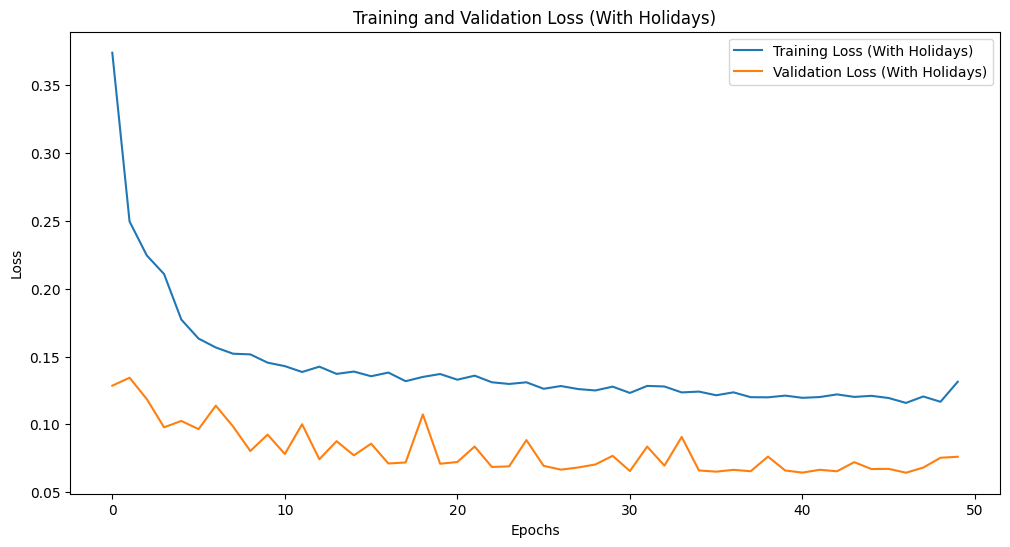

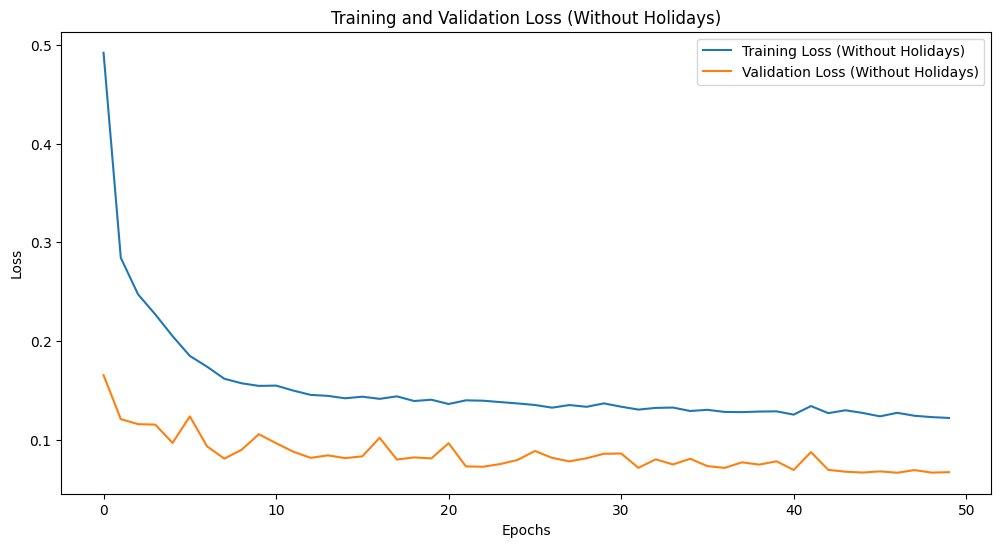

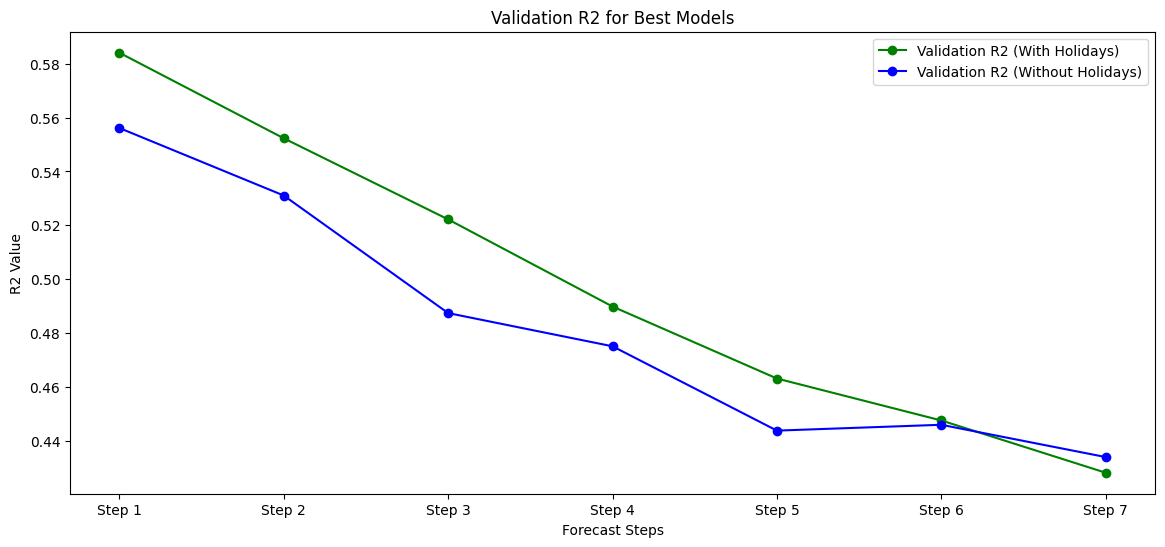

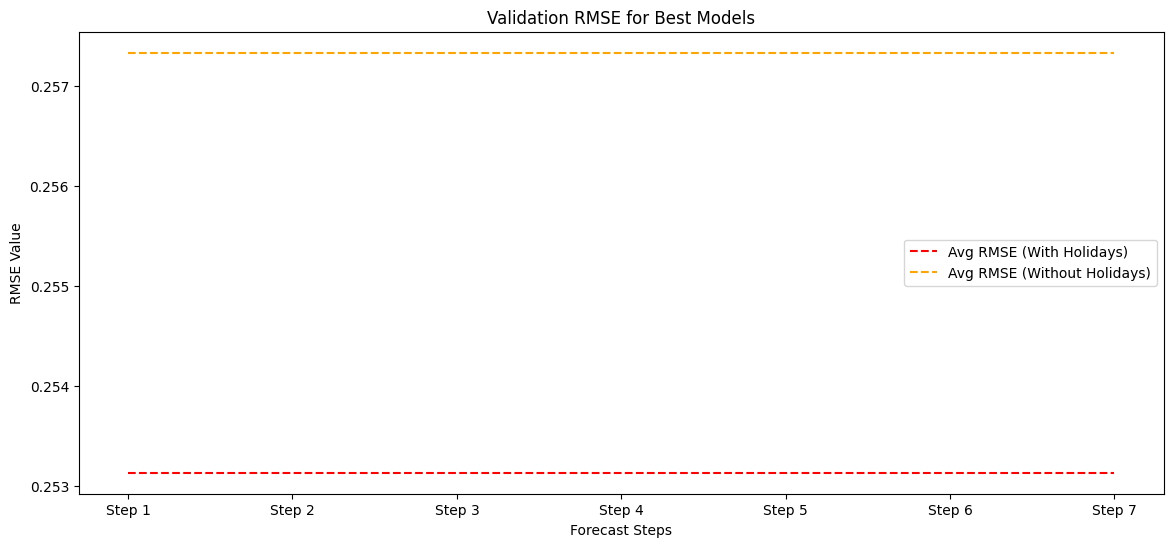

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
import holidays

# Load Data
data_path = '/kaggle/input/electricity-dataset-forecasting/household_power_consumption.txt'
data = pd.read_csv(data_path, sep=';', header=0, low_memory=False)

# Replace "?" with NaN
data.replace('?', np.nan, inplace=True)

# Handle datetime columns properly
data['datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], dayfirst=True)
data.drop(columns=['Date', 'Time'], inplace=True)
data.set_index('datetime', inplace=True)
data.sort_index(inplace=True)

# Convert numeric columns to proper data types
numeric_cols = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]
data[numeric_cols] = data[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Impute Missing Values
data = data.interpolate(method='time')  # Time-based interpolation for numeric values
data.dropna(inplace=True)  # Drop any remaining rows with missing values

# Aggregate minute-level data to daily level
data_daily = data.resample('D').mean()
data_daily.reset_index(inplace=True)
data_daily.rename(columns={'datetime': 'ds', 'Global_active_power': 'y'}, inplace=True)

# Feature Engineering
data_daily['day_of_week'] = data_daily['ds'].dt.dayofweek  # Numeric day of week (0=Monday, 6=Sunday)
data_daily['is_weekend'] = (data_daily['day_of_week'] >= 5).astype(int)
data_daily['is_holiday'] = data_daily['ds'].isin(pd.to_datetime(list(holidays.FR(years=data_daily['ds'].dt.year.unique())), errors='coerce')).astype(int)
data_daily['is_friday_and_holiday'] = ((data_daily['day_of_week'] == 4) & (data_daily['is_holiday'] == 1)).astype(int)
data_daily['is_monday_and_holiday'] = ((data_daily['day_of_week'] == 0) & (data_daily['is_holiday'] == 1)).astype(int)

# Adjusted split ranges based on the last date in the dataset
train = data_daily[(data_daily['ds'] >= '2006-12-16') & (data_daily['ds'] < '2009-11-01')]
val = data_daily[(data_daily['ds'] >= '2009-11-01') & (data_daily['ds'] < '2010-10-01')]
test = data_daily[(data_daily['ds'] >= '2010-10-01') & (data_daily['ds'] <= '2010-11-26')]

# Validate the test split
if len(test) < 30:
    print(f"Warning: Test data has only {len(test)} days. You may need to adjust the splits.")
else:
    print(f"Test data has {len(test)} days, suitable for evaluation.")

# Reframe data for multi-step forecasting
def to_supervised(data, n_input, n_output, features):
    X, y = [], []
    data_values = data[features].values
    for i in range(len(data_values) - n_input - n_output + 1):
        X.append(data_values[i:i + n_input])
        y.append(data_values[i + n_input:i + n_input + n_output, 0])
    return np.array(X), np.array(y)

# Define input and output window sizes
n_input = 30
n_output = 7

# Features for Experiment (With and Without Holidays)
features_with_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'is_weekend', 'is_holiday', 'is_friday_and_holiday', 'is_monday_and_holiday'
]
features_without_holidays = [
    'y', 'Global_reactive_power', 'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

X_train_holidays, y_train_holidays = to_supervised(train, n_input, n_output, features_with_holidays)
X_val_holidays, y_val_holidays = to_supervised(val, n_input, n_output, features_with_holidays)

X_train_no_holidays, y_train_no_holidays = to_supervised(train, n_input, n_output, features_without_holidays)
X_val_no_holidays, y_val_no_holidays = to_supervised(val, n_input, n_output, features_without_holidays)

# Improved Hyperparameter Grid
param_grid = {
    'gru_units': [128, 256],
    'dropout_rate': [0.2, 0.3],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64],
    'epochs': [50]  # Fixed for faster runs
}

# Function to build GRU model
def build_gru(gru_units, dropout_rate, learning_rate, n_input, n_output):
    model = Sequential()
    model.add(GRU(gru_units, return_sequences=True, input_shape=(n_input, X_train_holidays.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(gru_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_output))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# Function to tune model
def tune_model(X_train, y_train, X_val, y_val, param_grid):
    best_model, best_params, best_rmse, best_r2, best_history = None, None, float('inf'), None, None
    for params in ParameterGrid(param_grid):
        model = build_gru(
            gru_units=params['gru_units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            n_input=n_input,
            n_output=n_output
        )

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(
            X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
            validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping]
        )

        y_pred_val = model.predict(X_val)
        rmse_val = [np.sqrt(mean_squared_error(y_val[:, i], y_pred_val[:, i])) for i in range(n_output)]
        r2_val = [r2_score(y_val[:, i], y_pred_val[:, i]) for i in range(n_output)]

        if np.mean(rmse_val) < best_rmse:
            best_model, best_params, best_rmse, best_r2, best_history = model, params, np.mean(rmse_val), r2_val, history

    return best_model, best_params, best_rmse, best_r2, best_history

# Tune for "With Holidays"
best_model_holidays, best_params_holidays, best_rmse_holidays, best_r2_holidays, best_history_holidays = tune_model(
    X_train_holidays, y_train_holidays, X_val_holidays, y_val_holidays, param_grid
)

# Tune for "Without Holidays"
best_model_no_holidays, best_params_no_holidays, best_rmse_no_holidays, best_r2_no_holidays, best_history_no_holidays = tune_model(
    X_train_no_holidays, y_train_no_holidays, X_val_no_holidays, y_val_no_holidays, param_grid
)

# Plot training and validation loss for "With Holidays"
plt.figure(figsize=(12, 6))
plt.plot(best_history_holidays.history['loss'], label='Training Loss (With Holidays)')
plt.plot(best_history_holidays.history['val_loss'], label='Validation Loss (With Holidays)')
plt.title('Training and Validation Loss (With Holidays)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation loss for "Without Holidays"
plt.figure(figsize=(12, 6))
plt.plot(best_history_no_holidays.history['loss'], label='Training Loss (Without Holidays)')
plt.plot(best_history_no_holidays.history['val_loss'], label='Validation Loss (Without Holidays)')
plt.title('Training and Validation Loss (Without Holidays)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize RMSE and R2 for each step in the forecast horizon for both scenarios
steps = [f"Step {i+1}" for i in range(n_output)]

# Plot R2 values
plt.figure(figsize=(14, 6))
plt.plot(steps, best_r2_holidays, label='Validation R2 (With Holidays)', marker='o', color='green')
plt.plot(steps, best_r2_no_holidays, label='Validation R2 (Without Holidays)', marker='o', color='blue')
plt.title('Validation R2 for Best Models')
plt.xlabel('Forecast Steps')
plt.ylabel('R2 Value')
plt.legend()
plt.show()

# Plot RMSE values
plt.figure(figsize=(14, 6))
plt.plot(steps, [best_rmse_holidays] * len(steps), label='Avg RMSE (With Holidays)', linestyle='--', color='red')
plt.plot(steps, [best_rmse_no_holidays] * len(steps), label='Avg RMSE (Without Holidays)', linestyle='--', color='orange')
plt.title('Validation RMSE for Best Models')
plt.xlabel('Forecast Steps')
plt.ylabel('RMSE Value')
plt.legend()
plt.show()


In [27]:
# --------------------- Print RMSE and R² for Validation ---------------------

# Average RMSE and R² for "With Holidays"
print("\nValidation Results (With Holidays):")
print(f"Average RMSE: {best_rmse_holidays:.4f}")
print("Stepwise RMSE:", [f"{val:.4f}" for val in best_r2_holidays])
print(f"Average R²: {np.mean(best_r2_holidays):.4f}")
print("Stepwise R²:", [f"{val:.4f}" for val in best_r2_holidays])

# Average RMSE and R² for "Without Holidays"
print("\nValidation Results (Without Holidays):")
print(f"Average RMSE: {best_rmse_no_holidays:.4f}")
print("Stepwise RMSE:", [f"{val:.4f}" for val in best_r2_no_holidays])
print(f"Average R²: {np.mean(best_r2_no_holidays):.4f}")
print("Stepwise R²:", [f"{val:.4f}" for val in best_r2_no_holidays])



Validation Results (With Holidays):
Average RMSE: 0.2531
Stepwise RMSE: ['0.5840', '0.5523', '0.5222', '0.4898', '0.4631', '0.4476', '0.4282']
Average R²: 0.4982
Stepwise R²: ['0.5840', '0.5523', '0.5222', '0.4898', '0.4631', '0.4476', '0.4282']

Validation Results (Without Holidays):
Average RMSE: 0.2573
Stepwise RMSE: ['0.5561', '0.5310', '0.4874', '0.4751', '0.4438', '0.4460', '0.4340']
Average R²: 0.4819
Stepwise R²: ['0.5561', '0.5310', '0.4874', '0.4751', '0.4438', '0.4460', '0.4340']


# Since model is not performing well there is no point testing on test data.

In [30]:
# # ------------------------- Test Data Evaluation -------------------------

# # Function for rolling forecast on test data
# def rolling_forecast(model, test_data, n_input, n_output, features):
#     predictions = []
#     input_seq = test_data[features].values[:n_input]  # Initial input sequence (first n_input days)

#     for _ in range(len(test_data) - n_input):  # Loop through test data to predict
#         input_seq_reshaped = input_seq[-n_input:].reshape(1, n_input, len(features))  # Reshape for model input
#         pred = model.predict(input_seq_reshaped)  # Predict next n_output steps
#         predictions.append(pred.flatten())  # Store prediction
        
#         # Update input sequence by appending predicted values
#         new_input = test_data[features].iloc[len(input_seq):len(input_seq) + n_output].values
#         input_seq = np.vstack([input_seq, new_input])  # Append next values (or use predicted if unavailable)

#     # Combine predictions into a single array
#     predictions = np.array(predictions).flatten()[:len(test_data) - n_input]  # Match size with test data
#     return predictions

# # Define the features for the best model
# best_features = features_with_holidays if 'holidays' in str(best_model_holidays).lower() else features_without_holidays

# # Perform rolling forecast
# y_pred_test = rolling_forecast(best_model_holidays, test, n_input, n_output, best_features)

# # Ground truth for test data
# y_test_actual = test['y'].values[n_input:]

# # Evaluation metrics
# rmse_test = np.sqrt(mean_squared_error(y_test_actual, y_pred_test))
# r2_test = r2_score(y_test_actual, y_pred_test)

# print(f"Test RMSE: {rmse_test:.4f}")
# print(f"Test R²: {r2_test:.4f}")

# # ------------------------- Visualization of Test Results -------------------------

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(test['ds'][n_input:], y_test_actual, label='Actual', color='blue')
# plt.plot(test['ds'][n_input:], y_pred_test, label='Predicted', color='red')
# plt.title(f'Test Data Forecast\nTest RMSE: {rmse_test:.4f}, Test R²: {r2_test:.4f}')
# plt.xlabel('Date')
# plt.ylabel('Global Active Power (kW)')
# plt.legend()
# plt.show()

# # Plot residuals
# residuals_test = y_test_actual - y_pred_test
# plt.figure(figsize=(12, 6))
# plt.plot(test['ds'][n_input:], residuals_test, label='Residuals', color='purple')
# plt.axhline(0, color='black', linestyle='--')
# plt.title('Residuals on Test Data')
# plt.xlabel('Date')
# plt.ylabel('Residual')
# plt.legend()
# plt.show()

# # Histogram of residuals
# plt.figure(figsize=(10, 6))
# plt.hist(residuals_test, bins=20, color='skyblue', edgecolor='black')
# plt.title('Residuals Distribution')
# plt.xlabel('Residual Value')
# plt.ylabel('Frequency')
# plt.show()
